In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/sample_submission.csv


In [3]:
! pip install iterative-stratification

In [539]:
        
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau



import numpy as np 
import pandas as pd 
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, tnrange

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

plt.rcParams['figure.figsize'] = 25, 7

CGREEN  = '\33[32m'
CBLUE =  '\033[34m'
CRED = '\033[1;31m'
CEND  = '\33[0m'

def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [208]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
    
device

'cuda'

In [513]:

train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')


In [514]:
def preprocess(df):
    df = df.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    return df

train = preprocess(train_features)
test = preprocess(test_features)

del train_targets['sig_id']

target = train_targets.loc[train['cp_type']==0].reset_index(drop=True)
train = train.loc[train['cp_type']==0].reset_index(drop=True)

In [515]:
top_features = [  1,   2,   3,   4,   5,   6,   7,   9,  11,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  29,  30,  31,
        32,  33,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  78,  79,  80,  81,  82,  83,  84,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197,
       198, 199, 200, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226,
       227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
       254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
       267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
       281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294,
       295, 296, 298, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
       310, 311, 312, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
       324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
       337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
       350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
       363, 364, 365, 366, 367, 368, 369, 370, 371, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 390, 391,
       392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
       405, 406, 407, 408, 409, 411, 412, 413, 414, 415, 416, 417, 418,
       419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
       432, 434, 435, 436, 437, 438, 439, 440, 442, 443, 444, 445, 446,
       447, 448, 449, 450, 453, 454, 456, 457, 458, 459, 460, 461, 462,
       463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
       476, 477, 478, 479, 481, 482, 483, 484, 485, 486, 487, 488, 489,
       490, 491, 492, 493, 494, 495, 496, 498, 500, 501, 502, 503, 505,
       506, 507, 509, 510, 511, 512, 513, 514, 515, 518, 519, 520, 521,
       522, 523, 524, 525, 526, 527, 528, 530, 531, 532, 534, 535, 536,
       538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 549, 550, 551,
       552, 554, 557, 559, 560, 561, 562, 565, 566, 567, 568, 569, 570,
       571, 572, 573, 574, 575, 577, 578, 580, 581, 582, 583, 584, 585,
       586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599,
       600, 601, 602, 606, 607, 608, 609, 611, 612, 613, 615, 616, 617,
       618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630,
       631, 632, 633, 634, 635, 636, 637, 638, 639, 641, 642, 643, 644,
       645, 646, 647, 648, 649, 650, 651, 652, 654, 655, 656, 658, 659,
       660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672,
       673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685,
       686, 687, 688, 689, 691, 692, 693, 694, 695, 696, 697, 699, 700,
       701, 702, 704, 705, 707, 708, 709, 710, 711, 713, 714, 716, 717,
       718, 720, 721, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732,
       733, 734, 735, 737, 738, 739, 740, 742, 743, 744, 745, 746, 747,
       748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 759, 760, 761,
       762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774,
       775, 776, 777, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788,
       789, 790, 792, 793, 794, 795, 796, 797, 798, 800, 801, 802, 803,
       804, 805, 806, 808, 809, 811, 813, 814, 815, 816, 817, 818, 819,
       821, 822, 823, 825, 826, 827, 828, 829, 830, 831, 832, 834, 835,
       837, 838, 839, 840, 841, 842, 845, 846, 847, 848, 850, 851, 852,
       854, 855, 856, 858, 859, 860, 861, 862, 864, 866, 867, 868, 869,
       870, 871, 872, 873, 874]

In [516]:
all_columns = train.columns
train=train[all_columns[top_features]]
test = test[all_columns[top_features]]

In [517]:
train = train.values
test = test.values
target = target.values


In [518]:
train.shape, test.shape, target.shape

((21948, 785), (3982, 785), (21948, 206))

In [519]:
class TrainDataset(Dataset):
    def __init__(self, train,targets, noise ):
        
        self.features  = train
        self.targets = targets
        self.noise = noise
        
    def sizes(self):
        print("features size = ", self.features.shape[1])
        print("targets size = ", self.targets.shape[1])

        
    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx]).float()
        
#         if self.noise == True:
# #             print("noisy boi")
#             feature  = feature + torch.randn_like(feature)/150
            
        target = torch.tensor(self.targets[idx]).float()
        
        return feature, target

In [520]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

def train_step(x, y, model, optimizer, criterion):
    optimizer.zero_grad()
    pred = model(x.to(device))
    y = y.float()
    loss = criterion(pred,y.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

## Train test split for testing 

In [521]:
def validate_fn(model, val_loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch 
            pred = model(x.to(device))
            loss = criterion(pred.cpu(),y).item()
            losses.append(loss)
    return np.array(losses).mean()

def create_weights_from_val_losses(val_losses_np):
    w = 1/val_losses_np
    w_norm = w/w.max()
    return w_norm


def train_one_fold(model,num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 1, show_plots = False, train = True, validate = True):
    
    losses = []
    val_losses = []
    learning_rates = []    
    best_loss = 1000000

    for epoch in range(num_epochs):

            
        if train == True:
            model.train()
            losses_temp = []
            for batch in train_loader:
                (x_batch, y_batch) = batch
                loss = train_step(x_batch.to(device), y_batch.to(device), model, optimizer, criterion)
                losses_temp.append(loss)
            losses.append(torch.mean(torch.tensor(losses_temp)))
            
            if scheduler is not None:
                scheduler.step(1.)   ## lr decay caller 

            learning_rates.append(get_lr(optimizer))
            

        if validate == True:
            val_losses.append(validate_fn(model, val_loader, criterion, device))
            

        
        if train == True:
            print ("epoch ", epoch+1, " out of ", num_epochs, end = "      >" )

            if val_losses[-1] <= best_loss:

                print(CGREEN, "Val loss decreased from:", best_loss, " to ", val_losses[-1], CEND, end = "   >")
                best_loss = val_losses[-1]
                name = "./model_" + str(fold_number)+".pth"
                print("saving model as: ", name)
                torch.save(model.state_dict(), name)

            else: 
                print("showing no improvements, best loss yet:", best_loss)

        if show_plots == True:

            show_lr(learning_rates)
            plt.plot(val_losses, label = "val")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()


            plt.plot(val_losses[4:], label = "val after main drop", c = "g")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()


            plt.plot(losses, label = "train")
            plt.legend()
            plt.grid()
            plt.show()
        
    if train == True:
        return min(val_losses), name
    else:
        return min(val_losses)

## Creating folds for training 

In [522]:
train_main = train
target_main = target

In [563]:
num_folds = 2

mskf = MultilabelStratifiedKFold(n_splits=num_folds, shuffle=True, random_state=0)

train_loaders = []
val_loaders = []

for k , (train_idx,valid_idx) in enumerate(mskf.split(train_main,target_main)):

    x_train,x_valid,y_train,y_valid = train_main[train_idx,:],train_main[valid_idx,:],target_main[train_idx,:],target_main[valid_idx,:]

    input_size = x_train.shape[1]
    output_size = target.shape[1]


    train_dataset = TrainDataset(x_train, y_train, noise = False)
    valid_dataset = TrainDataset(x_valid, y_valid, noise = False)

    train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

    val_loader = DataLoader(dataset=valid_dataset, batch_size=256, shuffle = False)
    
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


86 batches 
43  batches 


# Model 1 

In [564]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(785)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(785, 2048))
        
        self.batch_norm2 = nn.BatchNorm1d(2048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(2048, 1048))
        
        self.batch_norm3 = nn.BatchNorm1d(1048)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(1048, 206))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

# Model 1 training 

In [580]:
model_filenames = []
val_losses = []
model_classes = []

num_epochs = 2 ## changes here 

k = 0
for train_loader, val_loader in zip(train_loaders,val_loaders):
    model = Model()
    model_classes.append(Model())
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = 0.004299882049752947, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min', 
                                                     factor=0.1, ## wooo hoo
                                                     patience=7, ## was 3 for 158 
                                                     eps=1e-4, 
                                                     verbose=True)


    criterion = nn.BCEWithLogitsLoss()

    val_loss, filename = train_one_fold(model, num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = k+1)

    val_losses.append(val_loss)
    model_filenames.append(filename)
    k+=1
    
print(CBLUE, "Training complete", CEND)

epoch  1  out of  2      > Val loss decreased from: 1000000  to  0.023430124921507613    >saving model as:  ./model_1.pth
epoch  2  out of  2      > Val loss decreased from: 0.023430124921507613  to  0.021255408132145572    >saving model as:  ./model_1.pth
epoch  1  out of  2      > Val loss decreased from: 1000000  to  0.02303785111668498    >saving model as:  ./model_2.pth
epoch  2  out of  2      > Val loss decreased from: 0.02303785111668498  to  0.020941597517839698    >saving model as:  ./model_2.pth
 Training complete 


In [581]:
model_filenames

['./model_1.pth', './model_2.pth']

# Model 2 

In [582]:
class Model_2(nn.Module):
    def __init__(self):
        super(Model_2, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(785)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(785, 512))
        
        self.batch_norm4 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.5)
        self.dense4 = nn.utils.weight_norm(nn.Linear(512, 206))
    
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm4(x)
        x = self.dropout4(x)
        x = self.dense4(x)
        
        return x

# Model 2 training

In [583]:
num_epochs = 2 ## changes here 



k = 0
for train_loader, val_loader in zip(train_loaders,val_loaders):
    model = Model_2()
    model_classes.append(Model_2())
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = 4e-3, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min', 
                                                     factor=0.1, ## wooo hoo
                                                     patience=7, ## was 3 for 158 
                                                     eps=1e-4, 
                                                     verbose=True)


    criterion = nn.BCEWithLogitsLoss()

    val_loss, filename = train_one_fold(model, num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 100 + k + 1)


    val_losses.append(val_loss)
    model_filenames.append(filename)
    
    k+=1
    
print(CBLUE, "Training complete", CEND)

epoch  1  out of  2      > Val loss decreased from: 1000000  to  0.027456313978100933    >saving model as:  ./model_101.pth
epoch  2  out of  2      > Val loss decreased from: 0.027456313978100933  to  0.02060639472721621    >saving model as:  ./model_101.pth
epoch  1  out of  2      > Val loss decreased from: 1000000  to  0.028843993840869084    >saving model as:  ./model_102.pth
epoch  2  out of  2      > Val loss decreased from: 0.028843993840869084  to  0.021207757120908693    >saving model as:  ./model_102.pth
 Training complete 


# Model blending

In [584]:
class blend(nn.Module):
    def __init__(self,weights, model_list ,model_filenames, device = device):
        super(blend, self).__init__()
#         print("loading models...")
        self.model_filenames = model_filenames
        self.model_list = model_list
        self.weights = weights 

        for i in range(len(self.model_filenames)):
            self.model_list[i].load_state_dict(torch.load(self.model_filenames[i]))
            self.model_list[i].to(device)
            self.model_list[i].eval()
            
#         print("done loading from", self.model_filenames)

    def forward(self, x):
        
        x_list = [self.model_list[i](x).detach().cpu() for i in range(len(self.model_list))]
        
        final_pred = torch.zeros_like(x_list[0])
        for i in range(len(x_list)):
            final_pred += x_list[i] * self.weights[i]
            
        final_pred = final_pred/self.weights.sum()
        
        return final_pred.cpu()

In [585]:
weights = create_weights_from_val_losses(np.array(val_losses))
bb = blend(
    weights = weights, 
    model_list = model_classes,
    model_filenames = model_filenames
)

In [586]:
model_filenames

['./model_1.pth', './model_2.pth', './model_101.pth', './model_102.pth']

In [587]:
all_models = model_classes
test_val_losses = {}

for i in range(len(model_filenames)):
    all_models[i].load_state_dict(torch.load(model_filenames[i]))
    all_models[i].to(device)
    all_models[i].eval()
    
all_val_losses = []

with torch.no_grad():
    for i in range(len(all_models)):
        val_loss = validate_fn(all_models[i], val_loader, criterion, device)
        test_val_losses["model_" + str(i+1)] = val_loss
    print("done validating")

test_val_losses

done validating


{'model_1': 0.02104137993829195,
 'model_2': 0.020941597517839698,
 'model_3': 0.020453175659789595,
 'model_4': 0.021207757120908693}

In [588]:
val_loss = validate_fn(bb, val_loader, criterion, device)
test_val_losses["model_blend"] = val_loss


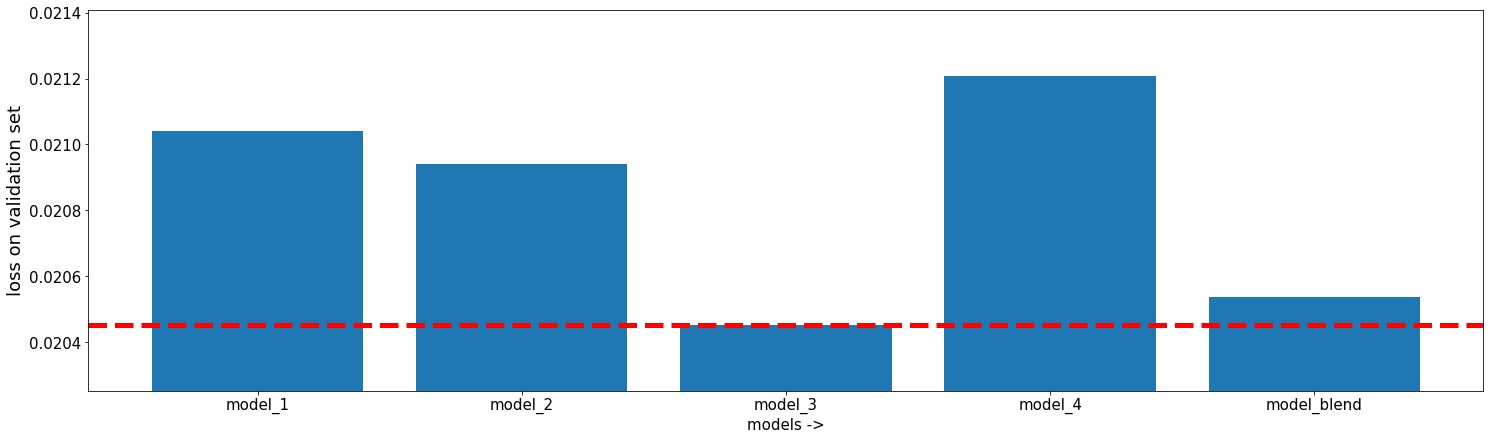

In [589]:
plt.rcParams.update({'font.size': 15})

names = test_val_losses.keys()
vals = test_val_losses.values()

plt.bar(names, vals)
plt.ylim(min(vals)- .0002, max(vals) + 0.0002)
plt.ylabel("loss on validation set", fontsize = 18)
plt.xlabel("models ->", fontsize = 15)
plt.axhline(y = min(vals), linestyle = "--", c = "r", linewidth = 5)
plt.show()

# Finding good weights, better than the ones made from val losses 

In [590]:
import optuna

In [591]:
weights

array([0.96946596, 0.98399345, 1.        , 0.97164422])

In [592]:
def validate_trial( val_loader, criterion, device, params):
    bb = blend(
    weights = np.array(list(params.values())), 
    model_list = model_classes,
    model_filenames = model_filenames
    )
    
    loss_ = validate_fn(bb,val_loader, criterion, device)
    return loss_

In [593]:
def objective(trial):
    params = {
        "w1": trial.suggest_uniform("w1", 0.1, 1.0),
        "w2": trial.suggest_uniform("w2", 0.1, 1.0),
        "w3": trial.suggest_uniform("w3", 0.1, 1.0),
        "w4": trial.suggest_uniform("w4", 0.1, 1.0)
#         "w5": trial.suggest_uniform("w5", 0.1, 1.0),
#         "w6": trial.suggest_uniform("w6", 0.1, 1.0),
#         "w7": trial.suggest_uniform("w7", 0.1, 1.0),
#         "w8": trial.suggest_uniform("w8", 0.1, 1.0),
#         "w9": trial.suggest_uniform("w9", 0.1, 1.0),
#         "w10": trial.suggest_uniform("w10", 0.001, 1.0),

    }
    loss_ = validate_trial(val_loader,criterion, device, params) 
    return loss_


In [594]:
study = optuna.create_study(direction="minimize")


[I 2020-10-01 07:11:04,067] A new study created in memory with name: no-name-d9103abe-c347-42fc-bb2d-06054fa1d79f


In [595]:
study.optimize(objective, n_trials=300)



[I 2020-10-01 07:11:11,946] Trial 0 finished with value: 0.020494481548666954 and parameters: {'w1': 0.5517030704892988, 'w2': 0.7691720155466719, 'w3': 0.5511988839214556, 'w4': 0.198941892967942}. Best is trial 0 with value: 0.020494481548666954.
[I 2020-10-01 07:11:12,489] Trial 1 finished with value: 0.02058479493094045 and parameters: {'w1': 0.7735715871080795, 'w2': 0.5551323245105796, 'w3': 0.223806323839805, 'w4': 0.33864104268849615}. Best is trial 0 with value: 0.020494481548666954.
[I 2020-10-01 07:11:13,044] Trial 2 finished with value: 0.02058778425981832 and parameters: {'w1': 0.17419616150222186, 'w2': 0.20069049229040242, 'w3': 0.807730860078575, 'w4': 0.7577781809457742}. Best is trial 0 with value: 0.020494481548666954.
[I 2020-10-01 07:11:13,706] Trial 3 finished with value: 0.020674963590017584 and parameters: {'w1': 0.17922955478610014, 'w2': 0.42392662208502807, 'w3': 0.2254655077152154, 'w4': 0.592910313040017}. Best is trial 0 with value: 0.020494481548666954.
[

[I 2020-10-01 07:11:30,992] Trial 32 finished with value: 0.020454301996979604 and parameters: {'w1': 0.4693333611698726, 'w2': 0.7763468742402404, 'w3': 0.8843296199485847, 'w4': 0.16288084204186679}. Best is trial 19 with value: 0.0204275154270405.
[I 2020-10-01 07:11:31,581] Trial 33 finished with value: 0.020451144077057063 and parameters: {'w1': 0.32332661036992855, 'w2': 0.5807655126759755, 'w3': 0.6788184109167114, 'w4': 0.10444134658629209}. Best is trial 19 with value: 0.0204275154270405.
[I 2020-10-01 07:11:32,170] Trial 34 finished with value: 0.020467263494813166 and parameters: {'w1': 0.5267383540135394, 'w2': 0.6654428662486302, 'w3': 0.779644561480749, 'w4': 0.26143689935234943}. Best is trial 19 with value: 0.0204275154270405.
[I 2020-10-01 07:11:32,739] Trial 35 finished with value: 0.020414993123606194 and parameters: {'w1': 0.7796349108733632, 'w2': 0.3656264669983501, 'w3': 0.943964837197667, 'w4': 0.16222106135240105}. Best is trial 35 with value: 0.020414993123606

[I 2020-10-01 07:11:51,471] Trial 64 finished with value: 0.020419282708750215 and parameters: {'w1': 0.6324961549868306, 'w2': 0.10437304641730344, 'w3': 0.7368998540529724, 'w4': 0.18631806840677118}. Best is trial 62 with value: 0.020393241803313412.
[I 2020-10-01 07:11:52,064] Trial 65 finished with value: 0.020396841386722965 and parameters: {'w1': 0.5499238500694525, 'w2': 0.1730721214967458, 'w3': 0.8279395223685557, 'w4': 0.1266991207098829}. Best is trial 62 with value: 0.020393241803313412.
[I 2020-10-01 07:11:52,649] Trial 66 finished with value: 0.02042147820425588 and parameters: {'w1': 0.5523694644873143, 'w2': 0.15709792033603792, 'w3': 0.8268072500197937, 'w4': 0.2313267592838904}. Best is trial 62 with value: 0.020393241803313412.
[I 2020-10-01 07:11:53,251] Trial 67 finished with value: 0.02040208295680756 and parameters: {'w1': 0.5889576936747807, 'w2': 0.26720875794331156, 'w3': 0.8781819437005037, 'w4': 0.130456037126845}. Best is trial 62 with value: 0.02039324180

[I 2020-10-01 07:12:10,668] Trial 96 finished with value: 0.020391439715790195 and parameters: {'w1': 0.4327598855783117, 'w2': 0.1360097741224328, 'w3': 0.8122537242613854, 'w4': 0.11637419945706995}. Best is trial 94 with value: 0.020381594943099244.
[I 2020-10-01 07:12:11,217] Trial 97 finished with value: 0.020409039936439936 and parameters: {'w1': 0.48999632430453643, 'w2': 0.14649046438293667, 'w3': 0.9318885860483904, 'w4': 0.20838914154128296}. Best is trial 94 with value: 0.020381594943099244.
[I 2020-10-01 07:12:11,769] Trial 98 finished with value: 0.020402089541041574 and parameters: {'w1': 0.4560849816858804, 'w2': 0.2047050006588484, 'w3': 0.9719116872435387, 'w4': 0.1670618372445096}. Best is trial 94 with value: 0.020381594943099244.
[I 2020-10-01 07:12:12,534] Trial 99 finished with value: 0.020391020187458326 and parameters: {'w1': 0.5151059630276983, 'w2': 0.10277896517717394, 'w3': 0.9234504942770045, 'w4': 0.14466995432243016}. Best is trial 94 with value: 0.020381

[I 2020-10-01 07:12:29,094] Trial 128 finished with value: 0.020405287139637525 and parameters: {'w1': 0.5176889411570171, 'w2': 0.10526261403715709, 'w3': 0.9174427677073775, 'w4': 0.2005673373049371}. Best is trial 94 with value: 0.020381594943099244.
[I 2020-10-01 07:12:29,644] Trial 129 finished with value: 0.02039538601110148 and parameters: {'w1': 0.5451644352489788, 'w2': 0.12360953904223018, 'w3': 0.997435884292357, 'w4': 0.17203683284901708}. Best is trial 94 with value: 0.020381594943099244.
[I 2020-10-01 07:12:30,192] Trial 130 finished with value: 0.02041163616055666 and parameters: {'w1': 0.4786737148830872, 'w2': 0.15817828040523976, 'w3': 0.9487909415562223, 'w4': 0.21878953629555073}. Best is trial 94 with value: 0.020381594943099244.
[I 2020-10-01 07:12:30,726] Trial 131 finished with value: 0.020383681019031725 and parameters: {'w1': 0.5281326533617571, 'w2': 0.10106813033084741, 'w3': 0.9315615731051893, 'w4': 0.116756748046}. Best is trial 94 with value: 0.020381594

[I 2020-10-01 07:12:47,689] Trial 160 finished with value: 0.02038446294013844 and parameters: {'w1': 0.48173404003614667, 'w2': 0.1934948093089795, 'w3': 0.9973323123779605, 'w4': 0.10043754365192731}. Best is trial 148 with value: 0.020378883798108545.
[I 2020-10-01 07:12:48,246] Trial 161 finished with value: 0.020384795877129533 and parameters: {'w1': 0.4479567472929154, 'w2': 0.1736330195970005, 'w3': 0.9815894946400338, 'w4': 0.10269822698010331}. Best is trial 148 with value: 0.020378883798108545.
[I 2020-10-01 07:12:48,786] Trial 162 finished with value: 0.02038152788787387 and parameters: {'w1': 0.46975170987978054, 'w2': 0.15128402993296947, 'w3': 0.9988462041555175, 'w4': 0.10008779677287769}. Best is trial 148 with value: 0.020378883798108545.
[I 2020-10-01 07:12:49,533] Trial 163 finished with value: 0.020394345009049703 and parameters: {'w1': 0.4690098238975887, 'w2': 0.1606314140349157, 'w3': 0.9983357997604883, 'w4': 0.15189903599807075}. Best is trial 148 with value: 0

[I 2020-10-01 07:13:06,249] Trial 192 finished with value: 0.020562070053677228 and parameters: {'w1': 0.45848178359615777, 'w2': 0.1423119830379329, 'w3': 0.96829497254381, 'w4': 0.9362919271540935}. Best is trial 148 with value: 0.020378883798108545.
[I 2020-10-01 07:13:06,893] Trial 193 finished with value: 0.020383891238029615 and parameters: {'w1': 0.40935111821651776, 'w2': 0.14688642441569838, 'w3': 0.9842650117281225, 'w4': 0.10098691449789049}. Best is trial 148 with value: 0.020378883798108545.
[I 2020-10-01 07:13:07,663] Trial 194 finished with value: 0.020388744165037952 and parameters: {'w1': 0.43172964681846415, 'w2': 0.12182194202862087, 'w3': 0.9536526126204201, 'w4': 0.12867532570080623}. Best is trial 148 with value: 0.020378883798108545.
[I 2020-10-01 07:13:08,433] Trial 195 finished with value: 0.02038504417205966 and parameters: {'w1': 0.451276300905912, 'w2': 0.1798140220852843, 'w3': 0.968572070877981, 'w4': 0.10085000756879212}. Best is trial 148 with value: 0.0

[I 2020-10-01 07:13:24,784] Trial 224 finished with value: 0.020379413439090863 and parameters: {'w1': 0.5037119452825368, 'w2': 0.11379149655300828, 'w3': 0.960344744709054, 'w4': 0.10010565275159977}. Best is trial 148 with value: 0.020378883798108545.
[I 2020-10-01 07:13:25,335] Trial 225 finished with value: 0.02038332118197929 and parameters: {'w1': 0.5044185746415787, 'w2': 0.11641510326751599, 'w3': 0.9695822486734849, 'w4': 0.1167123531319152}. Best is trial 148 with value: 0.020378883798108545.
[I 2020-10-01 07:13:25,882] Trial 226 finished with value: 0.020382390595799268 and parameters: {'w1': 0.5182306533807284, 'w2': 0.13906123648806537, 'w3': 0.9298622431231911, 'w4': 0.1009753056584751}. Best is trial 148 with value: 0.020378883798108545.
[I 2020-10-01 07:13:26,426] Trial 227 finished with value: 0.020379383636768476 and parameters: {'w1': 0.49122129988754215, 'w2': 0.11440812730863241, 'w3': 0.9694805049312542, 'w4': 0.10043111483745376}. Best is trial 148 with value: 0

[I 2020-10-01 07:13:43,871] Trial 256 finished with value: 0.020379675942104915 and parameters: {'w1': 0.5290182851770744, 'w2': 0.10168277765345193, 'w3': 0.9303549330630986, 'w4': 0.1001171401563793}. Best is trial 243 with value: 0.02037821428547072.
[I 2020-10-01 07:13:44,469] Trial 257 finished with value: 0.020379626257128493 and parameters: {'w1': 0.5263297559588139, 'w2': 0.10020741908319655, 'w3': 0.9285914345372664, 'w4': 0.10012081452070651}. Best is trial 243 with value: 0.02037821428547072.
[I 2020-10-01 07:13:45,057] Trial 258 finished with value: 0.02038563571350519 and parameters: {'w1': 0.5302531000712415, 'w2': 0.11457613028323235, 'w3': 0.9171132415646989, 'w4': 0.11868397255299844}. Best is trial 243 with value: 0.02037821428547072.
[I 2020-10-01 07:13:45,625] Trial 259 finished with value: 0.020393014344018558 and parameters: {'w1': 0.5198896795617896, 'w2': 0.11600987197597445, 'w3': 0.9346018995681988, 'w4': 0.15168699790047238}. Best is trial 243 with value: 0.0

[I 2020-10-01 07:14:02,855] Trial 288 finished with value: 0.02038261614913164 and parameters: {'w1': 0.5166047732757835, 'w2': 0.10107602091063604, 'w3': 0.9651552082685877, 'w4': 0.11752506745834028}. Best is trial 243 with value: 0.02037821428547072.
[I 2020-10-01 07:14:03,425] Trial 289 finished with value: 0.020396219479829766 and parameters: {'w1': 0.5617697509350774, 'w2': 0.11911049156594462, 'w3': 0.942936098144488, 'w4': 0.16588346833578888}. Best is trial 243 with value: 0.02037821428547072.
[I 2020-10-01 07:14:04,000] Trial 290 finished with value: 0.020389409865750822 and parameters: {'w1': 0.5361957190587134, 'w2': 0.11635803402837523, 'w3': 0.9112430581165188, 'w4': 0.13231286390735997}. Best is trial 243 with value: 0.02037821428547072.
[I 2020-10-01 07:14:04,558] Trial 291 finished with value: 0.020527603364614552 and parameters: {'w1': 0.5134970915406524, 'w2': 0.10156231563735203, 'w3': 0.8953164677076313, 'w4': 0.7303746856033362}. Best is trial 243 with value: 0.02

In [596]:
print("best_trial:")
best_trial = study.best_trial
best_trial.params

best_trial:


{'w1': 0.5473204536551803,
 'w2': 0.10004323572300304,
 'w3': 0.9723530562807914,
 'w4': 0.10028478068788721}

In [597]:
noice_weights = np.array(list(best_trial.params.values()))


bb = blend(
    weights = noice_weights, 
    model_list = model_classes,
    model_filenames = model_filenames
)

In [598]:
val_loss_op = validate_fn(bb, val_loader, criterion, device)
test_val_losses["blend_with_optuna"] = val_loss_op


test_val_losses

{'model_1': 0.02104137993829195,
 'model_2': 0.020941597517839698,
 'model_3': 0.020453175659789595,
 'model_4': 0.021207757120908693,
 'model_blend': 0.02053847718377446,
 'blend_with_optuna': 0.02037821428547072}

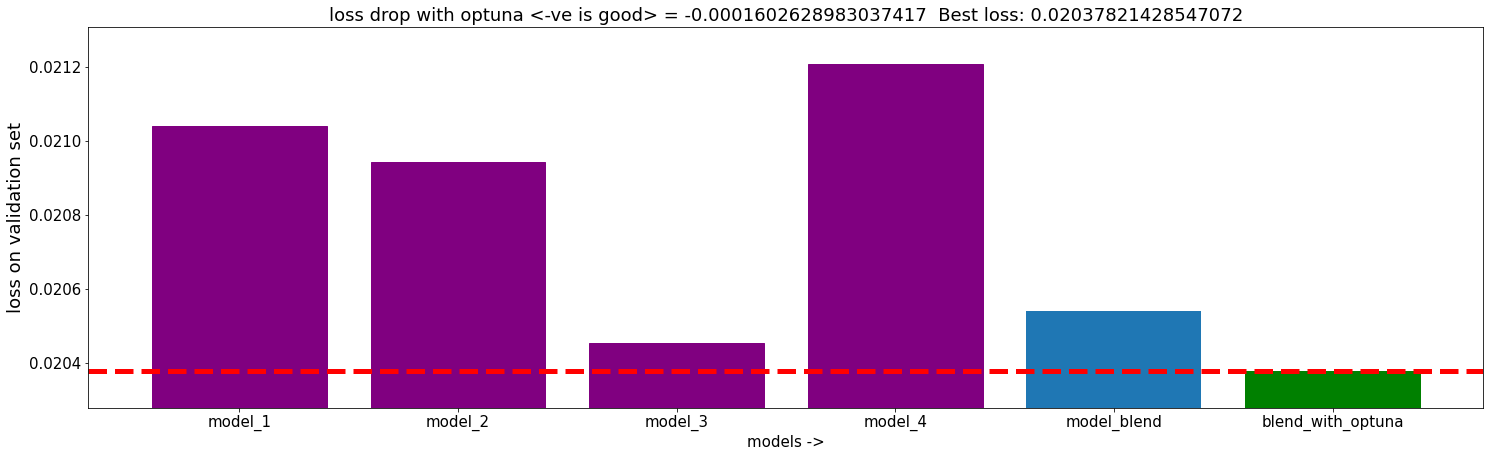

In [599]:
plt.rcParams.update({'font.size': 15})

names = test_val_losses.keys()
vals = test_val_losses.values()

bars = plt.bar(names, vals)

for i in range(4):
    bars[i].set_color("purple")


bars[-1].set_color("g")
plt.ylim(min(vals)- .0001, max(vals) + 0.0001)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABdIAAAHJCAYAAACBqMvsAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+j8jraAAAgAElEQVR4nOzdd5gsVZn48e9LlCBRBEXhAoqArhFUTARZEVBRlp+AugoLou6iyIoLa7yC4qIY1zUgC4gJlKQoLEmikkREkCRRyYgXULLw/v44p7lF356arp4ZZ+71+3meemb61KlTp6qrqrvfOnVOZCaSJEmSJEmSJGmwhaa7ApIkSZIkSZIkzWQG0iVJkiRJkiRJamEgXZIkSZIkSZKkFgbSJUmSJEmSJElqYSBdkiRJkiRJkqQWBtIlSZIkSZIkSWphIF2SxhERG0dERsSO012Xrubnuo8nImbVbZs9Ffn192NBPk8G+XvbXkn6W4uI2fU6O2u66yJJkiaPgXRJ0gIjIparP143nu66dFWDm7MjYrnpros0P4qIhSJij4i4IiIeiIg/RMTnImKpjuVsGRG/iIh7I+JPEfHDiFhjjLzLRsR/R8RNdZ2/jYj3RERMpOyIeEpEfCoi/i8i7qgBuUPHqfciEfG+iPhVLf/u+v+7Rq13RCwfEbtHxEl1f94fEVdGxIER8fSWuqwXEd+LiFsi4sGIuDEijomIlSdSdkSsFhHfiIira/6bIuK4iHjVgLyLRsSHIuLyWoc7I+KoiFhnImXXcr8eERdGxB9r2ddFxBER8YIxyh52f3cqOyJOr8fGWNPJg9+hx5b/Qc136YB5Qx+DMffmXNv08ra6jFPP/rL+WvflCRHxmlHL7bD+50f5fJ411euaKSLiWRFxbETMqdeTsyJi045lTNl1ZqacU1G8Jcp1/Y8R8edal49FxDJ9eTeKiP+JiEtqvjsi4ucRsUN/vWv+N0fEIRFxcUQ8HB1uzETEcxvLbDsJ+7vLtbdtH64/gXp3vs50OE46ld31vZS0YFlkuisgSdKIbgCWAP7aSFsO+Hj9//S/dYUmaGNK3Q8F7prWmvz9OZNyLD083RXRhHwBeB9wDPA5YN36+gURsVlmPjpeARGxDXAkcDHwQWBZ4P3AzyNi/cy8uZF3MeBk4AXAfwOXA1sAXwVWBmaPWjbwLOBDwB+AC2q5bfVeDPgxsAnwXeDrlO/5zwRWH5B32Hq/hLIvTwW+AvwReA7wLuDNEfGyzLysr/zNgWOBa4AvA7cBTwY2BJaprzuXHRFPBS6s2/UN4HfAU4F3AqdFxBsy86c1bwA/qtv1o7qdKwH/Cpw7kbKBxYD1gZ8D3wb+DKwG7AScFxGvzcyfjbi/O5UNfAo4iHltB7wOOG7AvF69Xgf8E3D/GFm6HIOXA/88IH1x4EDKe3t+y/LD+DXleAFYFJgF7AKcGBH/lJlHT7D8Ns+nfD6fDlw/heuZESJiLeAXlO9XnwHuppwLJ0bEFpl5yhBlTNl1ZoadU5+knCc/Az5B+R6xcf1/y4jYMDOz5t0feBrlM+oSYKla7veATSn7uOlf6765mHI9fdaAes0jIhYCvgk8ACw9IMuUXXsb/gjsMWDd106g3p2uMx2Pk67XsK7vpaQFSWY6OTk5ObVMlC/ECew43XWZqroDCwNLTnd9J2F7Z9Xtnd1l3kyYKF/oE5g13XWZwm1cHFh3uuvx9z4Nui5QfgSuPd11m8A2PRt4FDiqL/29dVvfMkQZiwI3UW7SLd1Ifz7wCHBgX/5/rWW/ty/9KOAhYPUJlP1EYKX6/5Pqeg5tqfu+lKDXJkNsZ5d6zwLWGlDGZrWMI/vSnwzcCZwALDpOPbqW/Z81feu+9GfU9GMbaW+sad/oy7smcB9wyqhlt2zPUyhBtONH3d9dy27JfwUlGLXCGPOXBn5PudFxPXDpgDydjsEx1rNDXe6zXZYbUE4CPxmQ/tw670cTKX+I9e9Y17Nxh2VmM59+pgM/qNel5/cdMzcAVwIxRBlTeZ2ZEecUJbB8LyXIvFBf/u/UOjb34UbAwn35FgLOqHmf0zdvNWCR+v9Xhj2egN2BvwAfq8ts2ze/6/7udH2k3nAa4bhrrXfLcgOvM5N0nIxVdqf30snJacGa7NpFkkYUEUtFxKcj4pooj4reGhGHRUR/67+IiPdHxG/q43/31Eco/zciFm3ke1mUx5RvrY8f3hQRx0fES4esz9YRcVHM7dJgH0rwpj/fjvURxc0i4qMRcQ3lx8GbO27XY/0sR8R7I+Kquu6rIuK9Q9b59Ii4vi/tLbXcX/elv6emv7i+flyf51G6c7muZv9441HMx5Vf874uIi6o9b0lIj4bEUM/pRURu0TpMuH+KN0nnBQRrxiQLyPi0Lqvz42I++r+/FI0upuI8rh8ryX9dY2697bt0IjI/vKb62i8fmy/DLOdEfHiWv5VtX5/jvJ46puG3R9t6vG/cUQcRGmJutcQy5wXEbcNek8iYvO6fe/vW8d7ojy63duG0yJikyHrOE+f4cOety1lLhkRn6/7/b76/r96rPcyIl4VESfX4+n+enztPEbZXfIOdV2gtNa9MiLOj9I9yJPH28YZZgcggC/2pX+TEjh92xBlbERpZXdQZv6ll5iZv6YEBrbre+/fUsv+Zl85X6Ts4+1GLTsz/5yZdwxRZ+q1ZHdKMPG0euw+sWWRoeudmddn5jX9BWRpkfonSivGpncDKwD/kZkP1/Ng4PkyQtm9bhJu7ku/lXIT5d5GWu/cP6Sv7GuBs4BXR8RqI5Y9ltspn6XL96V3OU66lj2PiHglpeXqMZn5pzGyfYoSBPzIWOV0OQZb7FL/DmrhOxl679dD/TMiYv0o3Qn1uvO4MiI+POAz8NlRuli6KeZ+5zktIraq82cz9zg6rfH5fOgoFa6f0d+un3EPRvmutV9ELNmXb4WI+EKd/0CUrokujIgP9uV7e71u3xWlC5ZrI+K7EbFSI8+SEbFORDxliPotBbwBOL1enwCo162DgLWBDYbY1Km8zsyUc2pRytNst+a8Tzz1js3Hrh2ZeUZmPtLMVJc7sr58Tt+832dm86nLcUXpmuWTlBs5vx+UZ4qvvc26LBQRy0SM39XJMPVuMdZ1ZjKOk4Fld30vJS1YDKRL0gjqD7ETgb2BX1EeX/w+JRh9XkQ8rZH9I5QuB66nBBE/SHkUcENKC10i4lmUxw/XBr5EaUXxP5RWDc8boj5vqmUuC+xDeYTx/1EePRzLAcD2lC+Yu1OCaF22q+e9Nf93KK1W7gK+HBEfH5C338+A1aM8RtyzKeWL+XObPwRr+j2Ulj+DXM7cx0iPoTyi+c+UrhOatgQOprSY3IPyyOyewH8MUV8iYn/KPnuY8jjv54D1KD+wtxywyAsp3RycU9dzFqW7iR9HeYwVyqOyx9T/92jUfSKPqg+7nW8C1qG0QNudEmBZATg6It4y6sprcOLTlBZspwHb1HV8eYjFv0Vp2fraAfPeTml5+71G2rcprbWupmzfbMq5cHJEvGHETRj3vB3HDyn7/dy67Nl1+UF9sr6eci6sSzmePkQ5vg6KiE9NIG+X68ItlOPyEco1qHcjb4f+AM+wImLxiHjSkNO4wYxxbEC5bjyu+4jMfIDSJcQwgZ9ennMGzDuXEkxYGx57BP2FwEV1HU3n17o01zl02SN4JaX18IUR8SXKdfKeKH227tcMHI5Q74EiYtm6ztv6Zm1Z179clJuh9wIPROlfeZj3oK3sE+vfr0bpn3bVWub3Ka0YP9fI2ztH7xuwil7aS0Ysu1fPheuxu0rN+z1Kq93jG3lG2t/DlN2id1NtYPA6ys3o3YD3Z+Y9Q5Q3kih9/28CnJ2ZV05CkYs2rherRMRLKF2hPQL8b9+6t6R05bE25b17H+Xc24fynvbyrUi5nr6Ksr/eA3weuIO5x8fRlK4dAPZj7ufzN7puQJQGCedTvlN9n/IZcSHlu9MJfUH+H1LepxMo37P2qctu3CjvbZTPywcorXjfT+na6VmUz9CeF1O+I316iGo+l3L+jHWtgnGuEVN5nZlJ51Rm3k/pGu61EbFXRDyj3ijZkfI9/juZ+bshyu99t+6/5o3iq5TuU/pvKo9rkq69PavWeXcDf4mIo2OM8SkmUu+xrjOTcQyOeA2bzPdS0kw13U3inZycnGb6xOBuEN5Z0z7Tl3ermv7tRtqvgMvGWcf76nIvHqF+C1Nab/wReFIjfVlKELO/7jvWtCvp686l43b19sufgac10hejfEl9uJk+Rt1fUct4ZyPtWkpgNIE317Sg/LD9cSPfLPq6ahmUNmDevTQeja1lXwrcMsS+fhbly/fZwGKN9KdSbiBcT+NRz7q+BN7YV86Xavr2jbTZjPHYLiVYkGPU6XGP23fdTmCpAWUuWY+P1uN2wHJPBT4AXFTrcB8leL51c38NUc4KwIPAD/rSn1i3q3kcvKmua9e+vIsAv6Q8pdD6GDqDz/Fxz9uW8ras5X1zjPRspC1MOU/vAp7adx79nBIkeuaIeYe+LvTVcy3go5TAS+8c/xbwj/Q9vj7OftixcQ6MN10/yr5urOsS4LYx5v2grqP1GKTcaEgGdD/E3EfEX1Nfr1hfHzFGWbcDvxil7AHzW7vVoNwAy7rOGynBwDdT+gZP4FuNvJ3q3bKvPlvL+Ze+9DmUc/ReynXrnyjXhF76s0ctu7Gv/th37FzVv1+Z26XP+/vSl6S0qkzg30cpu5H/OX1576IEWheZ6P4epuwxylum7udrGXDdo1wXLwZOaKRdz4CuXbocg2Mss29d5h3DLtNS1ljXjT8Bb+jL+wRKS9kz+/cXJXCd1C5aKC2vk/pdo2X9OzaXG7LOs+n7TKcEuRPYcoxjfuf6etn6+qvjrONoyo2r8Y6LjYd9/yjnbALvGTBvvTpvv3HKmLLrzAw8p1YFTukr+9F6/A/TBU7v++M1tHSHxRBdu1BaWD8KbNh33A7bRcqEr7017yGURhnbAdvWcu+nBNX/YTLrzRjXmck4Bscqe6LvpZOT0/w/2SJdkkbzJsqXvse17sky2M6vga0brY3vBlaNAV1/NNxd/24dEU/oWJcXAU8HDsnMPzbqcjdlwLmxfC0z+1vrddmunu9m5o2NvA9RWvIuArx+nLqfR/mBsik81lprDUorl0uBV9d8/0D5If+zAWV0dWxmXt+ob1JaTK8SEYMGN2ramhKQ/kzdzl4ZN1OCRqszb4vjKzPz2L60/6p/J6X7lDEMtZ2Z+dgjufXx7xUpwaafAetGxDKMIyJeExEnUwal25/yA+UdwMqZ+ebM/FFzf40ny6PTxwFviIjlGrO2rXX7ViPtbZRA77HNFs6UgWePo9xYeOaw624Y5rwdS++4/3wzMTOPpwSnm15E6Qf14GwMNln312cpTw9uPWLeUa4LZOY1mblvZq5byzmQci6eBNwYEZ+LRtdELU6kBN+Hmd46RHltlqTcfBnkgUae8cpgjHL6y2jL28vfXF+XsrvqdeOyArBZZn4tM3+QmVtTuo15e0SsN0Q9enVprUdEbEsJjp9IX9cptS5LUrpA2DEzj8rMz1GudUtSWs2OWjaUG6q/pDzlsTVzB239ae0aoOc7lOvQPhHxzohYo7agPJLyWcKA7Ry27J7rKMfuVpSbGVfV/M0nVkbd38OUPcgOtbyD6zW/3wcp18N/G6ecCYmIhSnBsHsoLasnw3nMvV68FtiVcrPw8CgD3Pb8I2UgwUMoT0Y0Pxd6rY9fU//2vnttMcxn3UTU705voLSQ7W8F/WnKd6/ed4L7KcfMSyJiVkuxd1Pe760ixu4+IzNPz8zIzB2HqOpkXKum8joz086pBylB9sMoXYnsQOmD+yOUJ8bGVJ/2OoYyRsmOmTnygOf1u9IXKTfwBz1NMN7yk3XtJTN3yswPZ+YRmXlkZn6Qcs4tTd/3oonUe5zrzISOwa7XsMl8LyXNfEP3BytJepw1gJszc86Aeb+lDCD3JMoP+Q9RuvY4KyJupgQ2fkoZzKcXXDycEhD8ELBHRJxL+TJ7eGbeME5d1qx/rxgw77KW5a4akNZlu3r6A4PN9a45YN5jsvShezZz+7N9NaXbjjMpgdxeVymb1r+TEUi/dkDanfXvipRHUceyRv372wHzLq1/16T82OiZZ/9k5i0RcRfj7J8JGmo7o/SF/UnKD6NB/WIvR/kh0eYtlEGq5lAeRT885+0vdB71MeIl+pLvyNLv5GGUlnFvZu5j9W+v6/hJI/+6DH4UuWllBh/vbYY5b8eyBiUocvWAeVfWOjfzwvjHVNe8o14XHiczfwX8KiK+AHwNeB3w75QW1q39RmfmLZQuYybFOMfLfQw+fqG0UIXB3Xw09eYPCqz0l9GWt5e/ub4uZXd1f/17bmb2v9+HUVqjbkR537vW+3FqlxnfpXRH8eYBgaX7KcGSQ5uJmXl6RPyeRrcUXcuOiHdSHv9/QWZe2kg/kfIEyaepfeFn5pyI2Iyy/Qc2ijmTcrPvIzSua13KbmzTvZSWqL28B9e8RwO9wO5I+3vIsgfZmfJkyjyBsIh4BuVGxiez9BU/lTandHHwjQE37Ef1xyx9OD8mIo4Afgd8MyLWqsGr3vX14JayVgbIzDMi4jBKwOytEXEBZb8fkZlDXyeHtBLl3Jjn+p2Zf4qIW6jX7cx8KMo4IF+ijJtyGeX7z7GZeWpj0f0o3dIcC9wZEWdQuoI5IjP/PGI9J+NaNZXXmZl0Ti0J/AL4VWZu35h1eEQcTrmRd2QO6BakNpo5Flif0uL5rJY6DOMAys30vbsuOJnX3rFk5lkRcSawSUQskaVbnAnVm/brzISOwXHKfpwpeC8lzXC2SJek0Yw7cE5PbWGxFqU17TGUYPR3gV9HxAo1z4OZ+Y+UPjk/TfnSvg9wRYw/6GOvLoNayrTVc9AXw6G3q6Hrevv9DFg5Ip5NCZhfkGVQq58Bz4gyINymlEdKLxmhfv0eaZk3Xr0na/90LWtgGdE+QOq421lbsJ1EaT1+GOXx2tdSWm31+iAf5rvCfpTg1F8ox/aNUQZJG68P1C9RAq3Nqdey6XhKC6i317quRgkGHp6ZzRZGvW5/2lo7X0pHw5y3LdrOybHyDmOUvCOfnxGxXETsHBGnUrqDeS3wf5TW4ze2LlyWX6L2RzvMtNJ45dF+vNwMPCkiBv1oXpUShBvvBkivlf+qY5QBcFP9O4cSNJ4nb63Dio28Xcvuqvde3DpgXu9GRq8P+q71bs5/LSXo9FtKNzSDbrCNV5eBfeEPWfZ/Alc0AzkAmXkJ5YbRRv3pmfkCSgvsjSjdHm3E3MBK86ZDp7IHqZ9bRwOvibnjfoy8v4cou7+8f6D0+ft/mTmozM9RukI5Jkpfzs+owfVFgMXq63EHoxxSaz/tk6UeJ+dQrgO9J49617cPMvZnwucaZbyD8tTbRyg3mz8A/CYidpvk6nb6/pCZX6c8UfVOSrByW+CUGqDt5fkdpbuVrShPaq1OGcPlirGOkyFMxrVqKq8zM+mc2pZy3A1qsfxDyvenQQPR9wKvm1G6NvzOePVtExEvBP6F0v3Lio1zu3dzeZWaNs/n41Rce1tcT+l2bvmJ1rtqu85M9DgZ6ho22e+lpPmDLdIlaTTXUAYXWi4z7+qbtx6lpVuzO4W/UB71PAogInqDie5M6ZKhl+986mB59VHJiyithXsDUY5VF3h8K1da0tp02q5G+ljrHabVW6+V+aspAfPeoGGnU4LB/0hpcXXSGI/VNg0TuJyI3r5+duP/nt5+6N/mefZPDVYs25e3re5/qsutULs96Zloi/bnUgaz3SczP95Xx12GLSQzrwL2joj/pLQ4/WfKj6P3R8TvKF31fG9Aq6zPULpgaLq1lvnXiPgesHtErEl5XDp4fLcuUFojrk1pjdv2NEFnw563A1xH+QH9TOZ9IuFZfa+bx1S//mNqlLydrgv1R+HrKE8ZbEkJOl5IaYX+/cy8faxlB9iOwY+ID3IDJWjUZszjBbiA8uj4iykD+gKPbc/zKS2Rx3NB/bshjZaL1Usp17+rADLz0Yj4FfCCiFi87+bOiynvf/PJlKHLHkFvgNVBg0H30m4fsd4AROk64xhK0GSzMZ5a6tVlnbre/htYT+PxTzN1LXtV5r3u9izCGL9rMvNqHv90yBaU/f3ziZY9QO+JiRWAa0bd38OUPWB+75o9VuBndUofvoOeaIFyLf0p5fwfWX3K6fXAbzJz2G2biEXr314XR73BHe/tb8E+lhogvBT4TJSuJs4D/isi/qd+75iM7xa3U7ohm+f6HWWw5adQutBr1usWyvt5UJSuJr4N7BARn8vMC2qeByk3no+vZW1JeR//ndG68LmE0h3GhgPmvbT+bX1fp/I6M8POqV6QduEB8xbp+ws8FsQ9hvJ5tWtmtj05MazVKN+P9qlTv/+ufzegsW+m+to7wDMpT532vseOVO9a99brzESOk2GvYVP0XkqaH+QM6KjdycnJaSZPtA82+l99ebeo6c1BOZ80oMyX1nyfbskTlCBc6yCYlC/wf2DeQQWXoX2w0Y0HlNVlu3r7ZazBRv8KPH2I/bsQ5Uv1ZbW8TRrzzqf86E/g3X3LzarpsxtpvcGFvjxgPfPkb8ybzTiDONV8vcFGz6IxkBDlB/Achh9s9Is1fYdG2gdq2gsHrPddDBgQDfgGfQOIddlO5g6+tU9fvudQfkiPu09a9tUTKIHU44CHalkXAtt0KOMFvW2h/NC7YkCebWue/x6jjJWHWE/vWG6eJ+Oety3l9QbnPbAvvW2w0TnAKo30Retx9ijzDjY6bN4u14UnUrrjuLvOu44yWNg6o7z/jfNisyGnl4+6nrquf6jbf1Rfem/QybcNqNs6NAZcrvvx5rp/lm6kP49yU++gvjL+rZb93r70oyiDLa8xatl95Y070CNlAORHaVw/6jFwXq3LaqPUu6a/htKy72JgxXHeh81q2cf2pb9+jHOiS9kX1X310r70DWv6j9uW7zseZo9aNqWLjnkG3QVWqe/xn/uOqy7HSaeyG/MXp5zrtzLG4In1vdl2wHQ7pa/xbRnjPBzmGGzk3XPQ9k5kquX9ZED6SsxtefrEmrYUpauvG4AVBiyzRCPvCmPs7/+r59MS9XVvAM4un1+z6fsMZe5go6/ty7t/Te8NNrrkGO/z3jXf5r33ZYxjJSk3PmmUtw7wlCHr/sN63D+vkbZ03adX0RhEk3JtW4fGNabrcV/Tu1wLZso5tXWtx08HzDuevu90tcwT6rG1a9s2DihvzMFGKTfIBp3bvWUOqK+XH3F/d7k+Lkvje3Ajvfe96PiJ1Lux7LjXma7HYMeyR34vnZyc5v/JFumSNJpDKd1h7BVlIKgzgWdQRrW/jccPMHR5lD7Pz6N8aX8KZZCshyh9owN8JCJeQ+n7+TpKEP31lB8nn2mrSGY+EhF7AD8Azo+Ib1KC2P9CeUx5tSnarp6rgPMi4uuUHyRvobQe2Tcz/zDeCrO0GjmT8oPkAUp/kz0/A/Zq/D9eWXdGxNXA9hFxTa3zvZl53HjLDiMzr4yIzwL/AZwZpX/WJ1Lez6WBt2bpr7npEuA79X35HaU/+G2BM4AjGvnOrX/3j4jvUvbFpVlayn2f0n3KgRGxDuV93YK5g+aN6nLKjYr/iNLX55WU1t3vorTOe+GoBWfmA5TtOyLKIG/bU/rQfD3lMeJhyrgoIi4B9qAEgOc5/jLzyIg4BNitPib8E8qP36dRfuQ9g9Fa7g9z3o7leMoYB++s234KpX/zXYHfUJ4E6NX/kdqFwDHABRFxIOU82o4SuN8vy+P7o+Ttcl1YkXIOHkFp9X1WZmaH/TWPnOQ+0sdZ1yUR8T+U4+BoynuwLvA+yrn2vb5FPk251m1CefqFLGM27E7ZB2fVfbYM5fi7A/h4XxnfBHYCPl+vl5dTbpa8idIP9XWN+nUtm4j4SP23NyDacxtpZ2Zms5X9eyk3U06JiC9T3uPtKC3v9snM349S74hYH/gR5TPpEMqgjI+rZzYeZc/MUyLi+5RWs8dTzsfVa/1uoQQXRyq77qNjgJPr583vKC0c30M5Lz/Rt/+Opzyh0btJ+xrgjZTWup/i8bqU/VbK0zbHUD6vH6JcN99B6bJgl3x8n7pD7+8Ryu55I+Uc/kxm/nXAfHKM1tkRcQDwl8w8csC8Lsdgz79QPr8mu4uDVSOi1w/zwpRr2M6UcTw+nLVP8My8NyLeTulu4coofWFfXfOtA2xD2fenU7oO26Pu76spwbWNKP0j/yDn9uN8ASVg9uHaevxe4LrMPK/jNnyI8pTdsRHx1brOV1HO1TOZ+8TV2sAZtV6XUm4WrEs5Hq9j7lM3J0XE3XXZP9Rt3JHa8KGx3hdTBhv/Vp0/nv+kDjAdZXyMeygNLVYFtur7bFiVckyfwePHQJiy60yXspnCc4pyfTsf2LJ+jz2qbsM2wCuBH2YZZ6Tnu5Qu0k4B7msczz2/yczfNPbLqyjHB5T+t6F8xt1V98kn69+bKQMpP07MHVj+3Ob5PcXX3k0o78txlOvvXynH39so383e31hHp3r3GeY60+U46Vp2p/dS0gJmuiP5Tk5OTjN9YkBr1Zq+FCUYcy3li+TtlB8uq/fl25vyI+d2SivfP1Ba+7ywbx1HUFo0309poX0e5bHSGLKe21AeC+6tY1/KD7bH1Z2WFukdt+ux/UIJVv2urvt3wO4d93GvleCpfem9+t84YJlZDG5Z+GLKI/v31vnXt+Wv82bTofU15QflRZQv2vcAJwOvHJAvKTcnNqvv5/2U4P5/U1vE9eX/j7rfH+6vK6X//J/Xdf6RMoDecr11jLdfxtpOSpDrh5Rg3n2UH4Vv6rpPOrzXS3fM32up/wgtTzhQupM5q74fD1DOpaOB7UY5xxnivB2nzKUoTx7cVt/38yhdFx0J3Dcg/0b1OOrV/yLKD/xBZXfJO+x1YVFg8cl8r//WEyW49gHKDaEHKf2ffn7QMVfPy4HXQUrXFufW82FOfc/WGmOdy1Faz91c13kZZcDdgdftjmVnyzR7QP7nAj8G7mocFztOpN7M/bwYcxpQ9iKUG6BXMvcz5DD6zt8Ry96U0grwTkqA5g5K8Or5A/J+lBnzf0EAACAASURBVBKE/EudLqDcFJ6ntWSXsoEXUYIoV9dyH6rn1hHAyya4vzuXXZc7qe6ztUc4b66n3LSdjGPwZXXedyf53B60/nso1+jtx1jmOZRA2E11P95GuVH/UWpLdUq3T9+q+/veWubFlOvI4n3lvaO+b70nrA4dp86zGfAZSrmp+u16XjxE+czfj8c/xbAi8AXKtfsuymfI1ZTPlKc08r2T8llway3rFspNxE361rnxMHXuW2ZdSrD1Lsr16mxK9x/9+WbVsk//G19nZsQ5RWlMsR/lqbkHKdfeSyjf5xbpy3v9ONs5uy//7Lb8Q7yHvf267STs72Gvj+tSvitdU/f3g/X//wFWHfLYG1jvUa4zwx4nXcvu+l46OTktWFNkJpIkdRURG1NaOO2UmYdOb21mpohI4FuZueN010UzQ21hv2hmrjPddZEkSZIkDW+h6a6AJEnSgiYilhiQthWlleTJf/saSZIkSZImwj7SJUmSJt/HIuIFlKc27qZ0IdDrn3z/6ayYJEmSJKk7A+mSJEmT7yzg5cAHgWUp4x4cBXw0M2+czopJkiRJkrqzj3RJkiRJkiRJklrYR7okSZIkSZIkSS3s2mWKPelJT8pZs2ZNdzUkSZIkSZIkSS0uvPDCP2bmSoPmGUifYrNmzeKXv/zldFdDkiRJkiRJktQiIm4Ya55du0iSJEmSJEmS1MJAuiRJkiRJkiRJLQykS5IkSZIkSZLUwkC6JEmSJEmSJEktDKRLkiRJkiRJktTCQLokSZIkSZIkSS0MpEuSJEmSJEmS1MJAuiRJkiRJkiRJLQykS5IkSZIkSZLUwkC6JEmSJEmSJEktDKRLkiRJkiRJktTCQLokSZIkSZIkSS0MpEuSJEmSJEmS1MJAuiRJkiRJkiRJLQykS5IkSZIkSZLUwkC6JEmSJEmSJEktDKRLkiRJkiRJktTCQLokSZIkSZIkSS0MpEuSJEmSJEmS1MJAuiRJkiRJkiRJLQykS5IkSZIkSZLUwkC6JEmSJEmSJEktDKRLkiRJkiRJktTCQLokSZIkSZIkSS0MpEuSJEmSJEmS1MJAuiRJkiRJkiRJLQykS5IkSZIkSZLUwkC6JEmSJEmSJEktDKRLkiRJkiRJktTCQLokSZIkSZIkSS0MpEuSJEmSJEmS1MJAuiRJkiRJkiRJLaY1kB4R60XEqRFxX0TcHBH7RMTCQyy3bEQcEhFzIuLuiPhuRKzYmL9wROwVEWdFxJ11OikiNugrZ7GI+GzNd39E5IB1DVWWJEmSJEmSJGnBNG2B9IhYHjgFSGBrYB/gA8Anhlj8CGBjYBdgR2AD4NjG/CWAvYELgH8G3gY8DJwdES9q5FuylnEf8Isx1jVsWZIkSZIkSZKkBdAi07jud1OC1Ntk5j3AyRGxDDA7Ij5T0+YRERsCmwMbZeaZNe0m4LyI2CwzTwHuB9bMzDmN5U4FrgJ2A3YCyMy7ImKFzMyI2A3YdMAqhypLkiRJkiRJkrRgms5A+hbAiX0B88OB/YGNgONalrutF0QHyMzzI+K6Ou+UzHwEmNNcKDMfiojfAk/uS5+nO5e++UOXJUmSJGliDljlAO697d7probU2VIrL8Wet+453dWQJElTZDr7SF8HuKKZkJm/p3Szsk6X5arL25aLiMWBFwGXda7pFJYlSZIkaS6D6JpfeexKkrRgm85A+vLAXQPS59R5k73ch+v8g4at4N+oLEmSJEmSJEnSDDadgXQoA432izHSR14uIraiBL/3yswrO9VwhLIiYteI+GVE/PKOO+6YyOokSZIkSZIkSdNsOgPpc4DlBqQvy+AW5+Mtt9yg5SJiA+AI4BuZ+cUR6tm5rMw8MDPXz8z1V1pppYmsUpIkSZIkSZI0zaYzkH4FfX2aR8TTgaUY3Af6mMtV8/SdHhFrAz8FTgXeO5HKTmZZkiRJkiRJkqT5x3QG0k8ANo+IJzbStgPuB84YZ7lVIuIVvYSIWB9Ys87rpT0FOBG4BtghMx8ZtaKTWZYkSZIkSZIkaf6yyDSu++vA+4CjI2J/SiB8NvD5zLynlykirgbOyMydATLznIg4ETgsIvYEHgX2B87OzFPqMktQgurLA7sBz42IXpEPZuZFjfK3oLSCf359vW2ddUFm3tClLEmSJEmSJEnSgmfaAumZOSciXg18BTiO0r/5FyjB9KZFgIX70raveQ+mtKr/CSUo37My8Lz6/0/6lr0BmNV4/TVg9cbrH9a/OwGHdixLkiRJkiRJkrSAmc4W6WTmZcCm4+SZNSDtLkqge6cxlrkeiEHzhil/1LIkSZIkSZIkSQue6ewjXZIkSZIkSZKkGc9AuiRJkiRJkiRJLQykS5IkSZIkSZLUwkC6JEmSJEmSJEktDKRLkiRJkiRJktTCQLokSZIkSZIkSS0MpEuSJEmSJEmS1MJAuiRJkiRJkiRJLQykS5IkSZIkSZLUwkC6JEmSJEmSJEktDKRLkiRJkiRJktTCQLokSZIkSZIkSS0MpEuSJEmSJEmS1MJAuiRJkiRJkiRJLQykS5IkSZIkSZLUwkC6JEmSJEmSJEktDKRLkiRJkiRJktTCQLokSZIkSZIkSS0MpEuSJEmSJEmS1MJAuiRJkiRJkiRJLQykS5IkSZIkSZLUwkC6JEmSJEmSJEktDKRLkiRJkiRJktTCQLokSZIkSZIkSS0MpEuSJEmSJEmS1MJAuiRJkiRJkiRJLQykS5IkSZIkSZLUwkC6JEmSJEmSJEktDKRLkiRJkiRJktTCQLokSZIkSZIkSS0MpEuSJEmSJEmS1MJAuiRJkiRJkiRJLQykS5IkSZIkSZLUwkC6JEmSJEmSJEktDKRLkiRJkiRJktTCQLokSZIkSZIkSS0MpEuSJEmSJEmS1MJAuiRJkiRJkiRJLQykS5IkSZIkSZLUwkC6JEmSJEmSJEktDKRLkiRJkiRJktTCQLokSZIkSZIkSS0MpEuSJEmSJEmS1MJAuiRJkiRJkiRJLQykS5IkSZIkSZLUwkC6JEmSJEmSJEktDKRLkiRJkiRJktTCQLokSZIkSZIkSS0MpEuSJEmSJEmS1GLoQHpEHBwRL2mZ/+KIOHhyqiVJkiRJkiRJ0szQpUX6jsBaLfPXAN4xodpIkiRJkiRJkjTDTGbXLksBD09ieZIkSZIkSZIkTbtF2mZGxGrArEbSOhHxqgFZVwDeA1w9eVXTguCAVQ7g3tvune5qSJ0ttfJS7HnrntNdDUmSJEmSJM0ArYF0YCfg40DW6cN16hfAozW/9BiD6JpfeexKkiRJkiSpZ7xA+rHA9ZRA+cHAgcA5fXkS+AtwQWb+YbIrKEmSJEmSJEnSdGoNpGfmxcDFABGxOnBUZl76t6iYJEmSJEmSJEkzwXgt0h+TmZ+YyopIkiRJkiRJkjQTLdQlc0Q8PSIOjogbI+KhiNi0pq9U0zeYmmpKkiRJkiRJkjQ9hg6kR8QawC+BfwJ+Cyzcm5eZdwDrA7tMdgUlSZIkSZIkSZpOQ3ftAnwKeBR4DnA/cHvf/OOB109SvSRJkiRJkiRJmhG6dO2yGfDVzPwDkAPm3wA8bVJqJUmSJEmSJEnSDNElkL4McEvL/MXo1sKdiFgvIk6NiPsi4uaI2CciFh5iuWUj4pCImBMRd0fEdyNixcb8hSNir4g4KyLurNNJ/X24R8RiEfHZmu/+iBh0g6CXd+uIuCQiHoiIyyJiuy7bKkmSJEmSJEmaP3UJpP8BeHbL/JcCVw9bWEQsD5xCad2+NbAP8AHgE0MsfgSwMaVP9h2BDYBjG/OXAPYGLgD+GXgb8DBwdkS8qJFvyVrGfcAvWur6CuAo4DRgC+CnwPcj4jVD1FWSJEmSJEmSNB/r0oL8aODdEfG/zG2ZngAR8U/A/wM+3qG8d1MC3ttk5j3AyRGxDDA7Ij5T0+YRERsCmwMbZeaZNe0m4LyI2CwzT6H04b5mZs5pLHcqcBWwG7ATQGbeFRErZGZGxG7ApmPU9aPAmZn5vvr6tIh4NvAx4KQO2yxJkiRJkiRJms90aZH+KeBG4DzgO5Qg+t4RcQ7wA+Bi4HMdytsCOLEvYH44Jbi+0TjL3dYLogNk5vnAdXUemflIM4he0x4Cfgs8uS99zO5cACJicWATyjY2HQ5sGBHLti0vSZIkSZIkSZq/DR1IrwHvDYGDgPWBAP4ReBbwVWCTzHygw7rXAa7oW8fvKd2srNNluerytuVqQPxFwGUd6giwFrDogHVeTtl/a3csT5IkSZIkSZI0H+k0OGgNpu8O7B4RK1GC6XeM16p7DMsDdw1In1PnjbLcmi3Lfbgue9CwFWysjwHrnNM3X5IkSZIkSZK0AOoUSG/KzDsmYf2DAvAxRvrIy0XEVpRA+gcy88pONRx7nTFWXSJiV2BXgNVWW23E1UmSJEmSJEmSZoKhu3aJiBdHxDv70raOiEsi4qaI2K/juucAyw1IX5bBLc7HW265QctFxAbAEcA3MvOLHevYW1+v/P71MWidmXlgZq6fmeuvtNJKI6xSkiRJkiRJkjRTdBls9OPAG3ovImI14PvAKsDdwF4RsVOH8q6gr0/ziHg6sBSD+0Afc7lqnr7TI2Jt4KfAqcB7O9St6Rrg4QHrXAd4FLhqxHIlSZIkSZIkSfOBLoH05wE/b7zentK9yfMzcz3gJGp3JkM6Adg8Ip7YSNsOuB84Y5zlVomIV/QSImJ9Sv/oJzTSngKcSAmE75CZj3So22My80HgNOD/9c3aDjgnM+8epVxJkiRJkiRJ0vyhSx/pKwK3Nl5vDpyZmTfV1z8G9u1Q3teB9wFHR8T+lED4bODzdVBTACLiauCMzNwZIDPPiYgTgcMiYk9Kq/D9gbMz85S6zBKUoPrywG7AcyN6XZrzYGZe1Ch/C0or+OfX19vWWRdk5g31/32B0yPii8CxwJZ1em2H7ZUkSZIkSZIkzYe6BNLvAlYGiIjFgZcCzX7RE1hi2MIyc05EvBr4CnBcLf8LlGB6fx0X7kvbvuY9mNKq/ieUoHzPypQW9NR5TTcAsxqvvwas3nj9w/p3J+DQWteza4D9k8B7gOuAt2TmSe1bKUmSJEmSJEma33UJpP8a2CUiTgHeBDyB0nVKzxrAbV1WnpmXAZuOk2fWgLS7KIHugX2yZ+b1lG5nhqnDPOWPke9YSmt0SZIkSZIkSdLfkS6B9H0p/aCfTwlSn5yZv2zMfx1w3iTWTZIkSZIkSZKkaTd0ID0zfxERL6T0jX43cHhvXkSsSAmyHzPpNZQkSZIkSZIkaRp1aZFOZl4FXDUg/U5gj8mqlCRJkiRJkiRJM8VC010BSZIkSZIkSZJmMgPpkiRJkiRJkiS1MJAuSZIkSZIkSVILA+mSJEmSJEmSJLUwkC5JkiRJkiRJUgsD6ZIkSZIkSZIktVik6wIRsSQwC1gRiP75mXnmxKslSZIkSZIkSdLMMHQgvQbQPw/sNMZyASSw8ORUTZIkSZIkSZKk6delRfqXgJ2B44GfAXdOSY0kSZIkSZIkSZpBugTS3wh8PzPfOlWVkSRJkiRJkiRppuky2OgSwOlTVA9JkiRJkiRJkmakLi3Sfwk8c6oqIkka3QGrHMC9t9073dWQOllq5aXY89Y9p7sakiRJkiSNq0uL9L2BnSJig6mqjCRpNAbRNT/yuJUkSZIkzS+6tEjfFbgROCcizgGuBR7py5OZufNkVU6SJEmSJEmSpOnWJZC+Y+P/l9epXwIG0iVJkiRJkiRJC4yhA+mZ2aUbGEmSJEmSJEmSFggGxyVJkiRJkiRJatGlaxcAIiKAFwBr1qRrgYsyMyezYpIkSZIkSZIkzQSdAukR8Vrgq8DqfbOuj4h/zcwTJ61mkiRJkiRJkiTNAEMH0iPi5cCPgXuBLwOX1lnPpgxE+uOI2CQzfzHZlZQkSZIkSZIkabp0aZH+MeBW4CWZeUtzRkR8Fjiv5nnt5FVPkiRJkiRJkqTp1WWw0ZcAB/YH0QFq2jeBl05WxSRJkiRJkiRJmgm6BNIXA/7cMv+emkeSJEmSJEmSpAVGl0D65cD2ETFPdzA1bbuaR5IkSZIkSZKkBUaXQPrXKN27nBoRW0XEGnV6HXBqnffVqaikJEmSJEmSJEnTZejBRjPzoIh4JrAn8IoBWT6bmf87aTWTJEmSJEmSJGkGGDqQDpCZe0XE/wJbA2sAAVwD/Dgzr5qC+kmSJEmSJEmSNK06BdIBasD8s1NQF0mSJEmSJEmSZpwufaRLkiRJkiRJkvR3Z8wW6RFxMJDArpn5SH09nszMnSetdpIkSZIkSZIkTbO2rl12pATS3wM8Ul+PJwED6ZIkSZIkSZKkBcaYgfTMXKjttSRJkiRJkiRJfw8MjkuSJEmSJEmS1GLoQHpEXBsRb2iZ/7qIuHZyqiVJkiRJkiRJ0szQpUX6LGDplvlLAatPqDaSJEmSJEmSJM0wk9m1y8rAfZNYniRJkiRJkiRJ027MwUYBIuJVwMaNpG0i4hkDsq4AbA/8evKqJkmSJEmSJEnS9GsNpAObAB+v/yewTZ0GuRrYY5LqJUmSJEmSJEnSjDBeIP2LwKFAANcC7wd+1Jcngb9k5p8mvXaSJEmSJEmSJE2z1kB6Zt4N3A0QEZsAl2XmHX+LikmSJEmSJEmSNBOM1yL9MZl5xlRWRJIkSZIkSZKkmWjoQDpARCwCvBF4CbA8sFBflszMnSepbpIkSZIkSZIkTbuhA+kRsQJwGvAcSp/pWf/S+D8BA+mSJEmSJEmSpAVGf4vyNp8E1gF2AdaiBM43B9YFvg9cAKw42RWUJEmSJEmSJGk6dQmkbwUclpmHAPfUtEcy88rMfBtwP/Dpya6gJEmSJEmSJEnTqUsgfRVKq3OAv9a/T2jMPxZ4w2RUSpIkSZIkSZKkmaJLIP1PwFL1/z8DDwNPb8x/mDIAqSRJkiRJkiRJC4wugfSrgPUAMvNR4CJgx4hYPCKWBN4OXDv5VZQkSZIkSZIkafp0CaSfBGwbEYvX158HXkJpqX47sD7whcmtniRJkiRJkiRJ02uRDnn3Aw7IzAcBMvMHEfFX4G3AI8CRmXnEFNRRkiRJkiRJkqRpM3QgPTMTeLAv7Wjg6MmulCRJkiRJkiRJM0WXrl0kSZIkSZIkSfq7M2aL9Ij42AjlZWbuO4H6SJIkSZIkSZI0o7R17TJ7QFrWvzEgPepfA+mSJEmSJEmSpAVGWyB9jb7XSwOHAX8FvgBcRgmerwfsQekm5u1TUEdJkiRJkiRJkqbNmIH0zLyh+ToivkwZbPRVmfnXxqyLI+JI4Ezg3cD7pqKikiRJkiRJkiRNhy6Djb4ZOLwviA5AZj4MHF7zSJIkSZIkSZK0wOgSSF8GWLZl/nI1jyRJkiRJkiRJC4wugfSLgN0iYq3+GRHxDODfgF91WXlErBcRp0bEfRFxc0TsExELD7HcshFxSETMiYi7I+K7EbFiY/7CEbFXRJwVEXfW6aSI2KBrWTXPYhHxsYi4OiLur38/ERGLd9leSZIkSZIkSdL8p22w0X57AScDv42IY4ErgQTWBbau/+89bGERsTxwCmXQ0q2BtYDPUYL7Hxln8SOAZwG7AI8C+wPHAq+s85eodTkE+HSt227A2RHxssy8sENZAP9F6f/9I5QbCi8EPklphb/7sNssSZIkSZIkSZr/DB1Iz8yzI2Jj4AvM2xf6ucC/Z+a5Hdb9bkrAe5vMvAc4OSKWAWZHxGdq2jwiYkNgc2CjzDyzpt0EnBcRm2XmKcD9wJqZOaex3KnAVZSA+k4dygJ4C/C1zPx8fX1aRKwKvBUD6ZIkSZIkSZK0QOvStQuZeV5mvgxYGdgQeBmwcma+rGMQHWAL4MS+gPnhlOD6RuMsd1sv8F3rdT5wXZ1HZj7SDKLXtIeA3wJP7lJWtShwd1897gKibQMlSZIkSZIkSfO/ToH0nsy8owbVz83MO0Zc9zrAFX3l/h64r84bernq8rblan/mL6J0JdO1rIOAd0XEyyNi6Yh4JfAe4Cst9ZQkSZIkSZIkLQC69JE+2ZantOruN6fOG2W5NVuW+3Bd9qARytqb0lL+7EbaVzNzn5b1SZIkSZIkSZIWAGMG0iPiUcrgm0tm5kP1dY5TXmZml+D8oPJimPV0WS4itqIE0j+QmVeOUNYHgbcB7wV+AzwP2Dci7szMjw1Y367ArgCrrbZa+5ZIkiRJkiRJkma0tqD3YZRg8iN9ryfLHGC5AenLMriVeHO5lQakLzdouYjYADgC+EZmfrFrWRHxJOCTwL9l5jfr/DMj4iHgKxHxlcy8vblwZh4IHAiw/vrrT+Y+kyRJkiRJkiT9jY0ZSM/MHdteT4Ir6OvTPCKeDizF4H7Lm8u9ckD6OsCxfeWtDfwUOJXSmnyUstakDDb66748F1H23+rA7UiSJEmSJEmSFkgjDTY6SU4ANo+IJzbStgPuB84YZ7lVIuIVvYSIWJ8S8D6hkfYU4ETgGmCHzHykv6Ahy7qh/n1h37Ivqn+vb6mrJEmSJEmSJGk+N52DjX4deB9wdETsTwlezwY+n5n39DJFxNXAGZm5M0BmnhMRJwKHRcSelH7c9wfOzsxT6jJLUALhywO7Ac+NiF6RD2bmRcOWlZm3RcSxwP4R8QRKH+nPr3X9YWbeMSV7R5IkSZIkSZI0I7QNNnrtCOVlZq41ZMY5EfFq4CvAcZQ+yb9ACVD313HhvrTta96DKa3qf0IJyvesTBkQlDqv6QZgVoeyAN4BfKymPxW4CfgGsG/rRkqSJEmSJEmS5nttLdJ/z+QOLjqPzLwM2HScPLMGpN0F7FSnQctcD8SgeV3LqnnuAfaskyRJkiRJkiTp70jbYKMb/w3rIUmSJEmSJEnSjDSdg41KkiRJkiRJkjTjGUiXJEmSJEmSJKlFWx/p84iItYA9gJcAyzNvIH7owUYlSZIkSZIkSZofDN0iPSL+AfgVsAuwGLAmcC/wBGAW8AhlgFJJkiRJkiRJkhYYXbp22Qd4CHge8OqatntmPhV4F7Ac8G+TWz1JkiRJkiRJkqZXl0D6K4ADM/NKIGtaAGTmN4ETgP+a3OpJkiRJkiRJkjS9ugTSnwhcU/9/qP5dqjH/55RguyRJkiRJkiRJC4wugfTbgFUAMvPPlP7R127MXx5YePKqJkmSJEmSJEnS9FukQ95fAxs0Xp8B7B4R51MC8rsBF09i3SRJkiRJkiRJmnZdWqR/D1gxIpaorz8KLAucBpxKGWz0Q5NbPUmSJEmSJEmSptfQLdIz8wjgiMbriyLi2cCbgEeAEzLz2smvoiRJkiRJkiRJ06dL1y7zyMw/AF+epLpIkiRJkiRJkjTjDN21S0QcHRFviIgJBd8lSZIkSZIkSZqfdOkjfQvgGODmiPhiRLxwiuokSZIkSZIkSdKM0SWQvjLwbvj/7d15mGVVeS/+7wsIiIogKIJKQKNRk6smglGDAaPGRIggkqtGY0QFjeJwAxEMiTRgVJAQErk3wRG9Py4Yo9eJkJZBmRIVokmc0IjiADLIIFeZBNbvj71LD4fq3XWqq+tUVX8+z3Oeqr322mu/+9RZXdXvWefd+XqS1yS5qKq+XFWHVNX26yU6AAAAAACYsjkn0ltrN7bW3tVae0qShyU5KsmmSY5N8t2qOqOqnr+e4gQAAAAAgKmYZEX6z7TWLmutHdlae0SS3ZK8J8lvJPn/FjI4AAAAAACYtnW6cWhV3SvJI/rHvRYkIgAAAAAAWEImTqRXVSV5RpIXJ9knyRZJfpjkxCTvX9DoAAAAAABgyuacSK+qX0mXPP+DJNsnuT3J6emS56e31m5fLxECAAAAAMAUTbIi/T/7rxcneWuSU1tr1y18SAAAAAAAsHRMkkg/Nsn7W2tfW1/BAAAAAADAUjPnRHpr7bD1GQgAAAAAACxFG007AAAAAAAAWMok0gEAAAAAYIBEOgAAAAAADJBIBwAAAACAARLpAAAAAAAwQCIdAAAAAAAGbDJJ56qqJE9P8vAk2ySpsS6ttXb0AsUGAAAAAABTN+dEelU9PMlHkzwyd0+gz2hJJNIBAAAAAFgxJlmR/o4kD0tyaJJzkly7XiICAAAAAIAlZJJE+m5JTmitHbe+ggEAAAAAgKVmkpuN3pbk2+srEAAAAAAAWIomSaSvTvIb6ysQAAAAAABYiiZJpP9JkidV1cFVten6CggAAAAAAJaSSWqkX5jkXkmOTfK2qroiyR1jfVpr7WELFRwAAAAAAEzbJIn07yZp6ysQAAAAAABYiuacSG+t7bEe4wAAAAAAgCVpkhrpAAAAAACwwZmktEuSpKoelmTvJA/tm76V5GOttUsXMjAAAAAAAFgKJkqkV9XRSQ5LsvHYrmOr6i2ttTctWGQAAAAAALAEzLm0S1W9NMnhST6X5DlJHt4/9knyr0kOr6r910eQAAAAAAAwLZOsSH91uiT6Hq2120faL62qf0pyfpKDkrxvAeMDAAAAAICpmuRmo49KctpYEj1J0red1vcBAAAAAIAVY5JE+m1J7j2w/z59HwAAAAAAWDEmSaRflOQVVbXd+I6qekCSA9OVfgEAAAAAgBVjkhrpRyc5O8nXquo9Sb7at/9ykv3TrUh/4cKGBwAAAAAA0zXnRHpr7byq2jfJiUkOHtv93SR/1Fo7fyGDAwAAAACAaZtkRXpaa5+oqtOTPD7JzkkqyaVJvtBau3M9xAcAAAAAAFM1USI9SfqE+UX9AwAAAAAAVrRJbjYKAAAAAAAbHIl0AAAAAAAYIJEOAAAAAAADJNIBAAAAAGCARDoAAAAAAAyQSAcAAAAAgAFzTqRX1ROq6oCxtr2r6ktVdXlVvWXhwwMAAAAAgOmaZEX6EUmePbNRVTsmOTXJA5P8KMmhVbX/woYHAAAAAADTNUki/bFJLhzZfn6SSvK41tqjk3wqyYELGBsAAAAAAEzdJIn0bZJcObL9zCTntdYu77c/nuThk5y8qh5dVWdX1U1VdUVVjygm3wAAIABJREFUHVVVG8/huPtW1fuq6vqq+lFVnVJV24zs37iqDq2q86vq2v7xqaraddKxRvptU1UnVdWVVXVzVV1SVS+e5HoBAAAAAFh+Jkmk35BkuySpqs2SPDHJeSP7W5J7znWwqto6yVn9cXsnOSrJwUmOnMPhH0yyR5KXJ3lJkl2TfHRk/z2THJbkoiR/mORFSX6a5IKqevyEY6Wqtkx3rY9L8pokz0ryjiSbziFWAAAAAACWsU0m6PvvSV5eVWcleU6SzZOsHtm/c5KrJhjvlekS3vu21m5McmafsF5VVcf2bXdTVU9Ktxp+99baeX3b5Uk+V1VPb62dleTmJA9trV0/ctzZSb6R5KAk+08wVpL8WZLNkuzSWru5b/v0BNcKAAAAAMAyNcmK9KOTbJ/k8+kSy2e11i4e2b9Xks9NMN7vJlk9ljA/LV1yffe1HHfVTOI7SVprn0/y7X5fWmt3jCbR+7bbknwlyQMmGau3f5L3jCTRAQAAAADYQMw5kd5a+5ckv5bk9elKoPzezL6+pvinkvzdBOd+ZJJLxs7x3SQ39fvmfFzva0PH9eVoHp/kq5OMVVU7p0u+31BV/1RVt1XVNVV1fFUp7QIAAAAAsMJNUtolrbVvpCuPMt5+bZL/MeG5t05Xd33c9f2++Rz30IHjDu+PffeEYz2w/3psuhXzv5PksUnekuT2JG8YOCcAAAAAAMvcnBPpVbVxks1aazeNtG2V5GVJ7pfk1Nbalyc8f5vtVGton/dxVbVnukT6wa21r0841syq/a+01g7ovz+nqu6T5M+qatXoc9Kf78AkBybJjjvuuJZLAQAAAABgKZukRvpJ6eqjJ0mq6h5JLkjy9iRvTHJRVT1ugvGuT7LVLO33zeyrxNd23FazHVdVuyb5YJKTWmsnzGOs6/qv4zcXPSfdDUgfNn5wa+2drbVdWmu73P/+91/TdQAAAAAAsAxMkkjfLcnHR7b3S/LoJK9O8uQkVyU5bILxLslYTfOqekiSe2X2uuVrPK53t3rnVfWIJKcnOTvJa+Y51qVJbpulT/Vf7xyIFQAAAACAZW6SRPr2Sb49sr1nunInf9da+2ySdyZ50gTjnZHkmX2JlBnPS3JzknPXctwDq2q3mYaq2iVdTfMzRtq2T7I6XSL8Ba21O+YzVmvttiRnJvmtsWOflu7GqN8cvkwAAAAAAJazSW42Wkk2HtneI8lHRrZ/kOQBE4z390lem+QjVXVMuuT1qiTHt9Zu/NlJq76Z5NzW2suSpLX2r1W1OskHquqQdCvCj0lyQWvtrP6Ye6ZLhG+d5KAkj6maWUCeW1trX5zrWL2jklxQVe9LcmqSx6RbfX90a+3WCa4ZAAAAAIBlZpJE+reTPDPJ31fVb6RboT5aN3yHJD+a62Ctteur6mlJTkzyiXQ1yf86XTJ9PMaNx9qe3/d9b7pV9Z9Ml5SfsV2Sx/bff3Ls2O8k2WmCsdJa+3xV/V6Styb5gyRXJ/nLfhsAAAAAgBVskkT6+5IcX1VfTvKgdMnk1SP7fz3Dtc3vprX21dy9ZMp4n51mabshyf79Y7ZjLsvPa5ivLYbBsUb6rc5drxcAAAAAgA3AnGukt9ZOSHJEkluTfDHJc1prNyVJVW2T5IlJ/ml9BAkAAAAAANMyyYr0tNaOTnL0LO3XZrL66AAAAAAAsCzMeUX6uKratqq2XchgAAAAAABgqZkokV5VO1TV+6vqhiRXJbmqqq6vqpOr6kHrJ0QAAAAAAJieOZd2qaodk3w2yQOT/HuSr/S7Hp3kxUmeUVVPbK19b8GjBAAAAACAKZmkRvrRSbZOsldr7S43Fa2q303ykb7PSxYsOgAAAAAAmLJJSrv8dpL/NZ5ET5LW2hlJ/i7J7yxUYAAAAAAAsBRMkkjfOsl/Dez/ryRbrVs4AAAAAACwtEySSP9+kj0G9v9m3wcAAAAAAFaMSRLpH0ry+1X11qq670xjVW1ZVW9J8t+TfHChAwQAAAAAgGma9GajT0lyaJJDquqKvn2HJBsnuTDJmxc2PAAAAAAAmK45r0hvrd2UZPckr0jyqSQ/SXJTktVJDkzy1NbazesjSAAAAAAAmJZJVqSntXZHknf1DwAAAAAAWPEmqZEOAAAAAAAbnDWuSK+qF89nwNbaB+YfDgAAAAAALC1DpV1OTtKS1ATjtSQS6QAAALBE7XTY6dMOAeblsrftOe0QgA3YUCL9qYsWBQAAAAAALFFrTKS31s5dzEAAAAAAAGApcrNRAAAAAAAYIJEOAAAAAAADJNIBAAAAAGCARDoAAAAAAAyQSAcAAAAAgAES6QAAAAAAMEAiHQAAAAAABkikAwAAAADAAIl0AAAAAAAYIJEOAAAAAAADJNIBAAAAAGCARDoAAAAAAAyQSAcAAAAAgAES6QAAAAAAMEAiHQAAAAAABkikAwAAAADAAIl0AAAAAAAYIJEOAAAAAAADJNIBAAAAAGCARDoAAAAAAAyQSAcAAAAAgAES6QAAAAAAMEAiHQAAAAAABkikAwAAAADAAIl0AAAAAAAYIJEOAAAAAAADJNIBAAAAAGCARDoAAAAAAAyQSAcAAAAAgAGbTDsAAIDl4LgHHpefXPWTaYcBE7vXdvfKIVceMu0wAABgWbMiHQBgDiTRWa68dgEAYN1JpAMAAAAAwACJdAAAAAAAGCCRDgAAAAAAAyTSAQAAAABggEQ6AAAAAAAMkEgHAAAAAIABEukAAAAAADBAIh0AAAAAAAZIpAMAAAAAwACJdAAAAAAAGCCRDgAAAAAAAyTSAQAAAABgwFQT6VX16Ko6u6puqqorquqoqtp4Dsfdt6reV1XXV9WPquqUqtpmZP/GVXVoVZ1fVdf2j09V1a6TjjVL/32qqlXVxfO/cgAAAAAAloupJdKrauskZyVpSfZOclSSg5McOYfDP5hkjyQvT/KSJLsm+ejI/nsmOSzJRUn+MMmLkvw0yQVV9fgJxxqNefMkxye5ag4xAgAAAACwAmwyxXO/Ml3Ce9/W2o1JzqyqLZOsqqpj+7a7qaonJXlmkt1ba+f1bZcn+VxVPb21dlaSm5M8tLV2/chxZyf5RpKDkuw/wVij/jTJ5UkuTfIrC/IsAAAAAACwpE2ztMvvJlk9ljA/LV1yffe1HHfVTOI7SVprn0/y7X5fWmt3jCbR+7bbknwlyQMmGWtGVe2Y5A1JXjfXCwQAAAAAYPmbZiL9kUkuGW1orX03yU39vjkf1/va0HFVtVmSxyf56jzH+qsk/9Ba+8JAbAAAAAAArDDTLO2ydZIbZmm/vt83n+MeOnDc4f2x7550rKp6aroSMI8YGB8AAAAAgBVomivSk+5Go+NqDe3zPq6q9kyXSD+0tfb1Scaqqk2S/G2SN7fWrlxLXDPnO7CqLq6qi6+55pq5HAIAAAAAwBI1zUT69Um2mqX9vpl9lfjajttqtuOqatckH0xyUmvthHmMdUC//f6q2qqqtkqyaZKN++17jB/cWntna22X1tou97///QcuBQAAAACApW6aifRLMlaHvKoekuRemb1u+RqP692t3nlVPSLJ6UnOTvKaeY71S0kenOTKdIn365O8IMnj+u+fNxArAAAAAADL3DQT6WckeWZV3Wek7XlJbk5y7lqOe2BV7TbTUFW7pKtpfsZI2/ZJVie5NMkLWmt3zHOsE5M8deyxOsk3+u/PnMvFAgAAAACwPE3zZqN/n+S1ST5SVcekS16vSnJ8a+3GmU5V9c0k57bWXpYkrbV/rarVST5QVYckuTPJMUkuaK2d1R9zz3SJ8K2THJTkMVU1M+StrbUvznWs1to3k3xzNPCqekmSbVtrn1nQZwQAAAAAgCVnaon01tr1VfW0dCu+P5GuJvlfp0umj9okycZjbc/v+7433ar6T6ZLys/YLslj++8/OXbsd5LsNMFYAAAAAABswKq1Nu0YVrRddtihXfyDHyzMYGv7Wf181f26OeKIZNWqNe9ftSo58sgFOdWRd3vfZCyUteyfq89k95ybp65x/+75dPYYrCg0d65p/lbiNZlP68Y1zd9KvKbFnE+z/c49sn4+tp/TmrmmdbOhzKe7WKC/YVfiz8k1rZtpXNMR7Yi7d1iG8+mE33hBTtjthWvc//oLTsnrLzx1Qc6106Hja9/u6rJj9lqQ87imdbNUrumyzS9advNpJf7OdU3ryDXN3yJcUyX/1lrbZbZ906yRDgAAAAAAS940a6QDAAAAwIq16jNH5siBFbJHfObuNY7nq44cXvW7UDUpXNO6WYnXtKGwIh0AAAAAAAZIpAMAAAAAwAA3G13Pdtlll3bxxRdPO4ypGb0xGyw3s94saoky11iuzDNYHOYaLI7lMtd2Ouz0aYcA83LZ2/acdggTWVsJD1jK2hEbZs64qtxsFAAAAAAA5kMiHQAAAAAABkikAwAAAADAAIl0AAAAAAAYIJEOAAAAAAADJNIBAAAAAGCARDoAAAAAAAyQSAcAAAAAgAES6QAAAAAAMEAiHQAAAAAABkikAwAAAADAAIl0AAAAAAAYIJEOAAAAAAADJNIBAAAAAGCARDoAAAAAAAyQSAcAAAAAgAES6QAAAAAAMEAiHQAAAAAABkikAwAAAADAAIl0AAAAAAAYIJEOAAAAAAADJNIBAAAAAGCARDoAAAAAAAyQSAcAAAAAgAES6QAAAAAAMEAiHQAAAAAABkikAwAAAADAAIl0AAAAAAAYIJEOAAAAAAADJNIBAAAAAGCARDoAAAAAAAyQSAcAAAAAgAES6QAAAAAAMKBaa9OOYUWrqmuSfGfacbAibZvkh9MOAjYA5hosDnMN1j/zDBaHuQaLw1xjffiF1tr9Z9shkQ7LVFVd3FrbZdpxwEpnrsHiMNdg/TPPYHGYa7A4zDUWm9IuAAAAAAAwQCIdAAAAAAAGSKTD8vXOaQcAGwhzDRaHuQbrn3kGi8Ncg8VhrrGo1EgHAAAAAIABVqQDAAAAAMAAiXRYZqpqr6pqVbXThMddVlXHTdD/VVV1elVd259vjwlDhWVrMeZZVW1fVW+vqv+oqh9X1feq6v1VtcN8YoblaJHm2qZV9Q9V9a2qurmqrqmqM6rq8fOJGZajxfr7cezYE/pzzut4WGyL9Dtpp/4ce62l36qq+uEkcayrqvphVa1azHMyd1V1clVdvJY+raoOWsSYDqqq9VbmYnweVNUj+ratxvq9pL/2e6+vWCZRVU8wl1YuiXRgTV6c5H5JVk87EFihHp/kOUlOTfJ7Sf40ya8n+Zel8kcgrBAbJ2lJ3ppkzyQHJNkiyTlV9dBpBgYrVVU9OslLk9w47VgAWLbeneSZI9uPSHJEkq1m775kPCFdnKxAm0w7AGDJenJr7c6q+pUkL5h2MLACXZDkka2122caquoLSb6e5LlJ3j+twGAlaa3dnOR5o21VdVaSa5Psk+T4acQFK9zfJvmbJH847UAAWJ5aa99P8v1pxwGjrEiHdTTzEauq2rOqvlpVN/UlUe5XVb9YVZ+uqp/0fR4zctwWVfW3VXVlVd1SVRdV1W+PjV39R5eurqr/V1UfSLLlLDFsXlXH9qUhbu1LRTxrXa6rtXbnuhwPC2klzrPW2g2jSfS+7RtJbkrygPmOC+tiJc61NfhJkluSbLrA48KcrOS5VlX7JXlUkret61hs2FbyPEmyZVX97/7cV1fVWlev9td9UlVd1V/Xv1TVr4/1aVX1uqp6S3WlzK6uqv9ZVZuN9fvN/lpuqap/q6onL8A1sQiqap+quqT/2V1Q3SeAhvrv3c+RW/o5cWxV3WNk/6rqyvr8alV9tp9nX6yqp4yNs1lVnVhVN1TVdVX110nucbcTrjmOl/bzdfTcV/Tnrn57o378A0Zj67/fI8kn+kO/3b/WLxs7zc5VdWZ/nkuqat+5xtefY+eq+mhV3djPzU9U1S+O9WlV9SdV9Tf983BDVb2jqjbt978kyTtG+raq+ky/fbfyPDVLuae5zOPqyoS+t35euvAbVfXmmThYfyTSYWHsmOSoJH+e5MAkT07yziSn9Y/90n0C5LSZXxJJ3pVk/yR/ma68w/eSnF5Vu42M+9okb+rH2i/JzUmOneX8/5jkJUnekq5ExEVJPl5Vj1uwK4TpW/HzrLr/BG6R5KsLNSbMw4qca9XZpKoe2J/3jnSllWBaVtxcq6p7JvmrJIe11n4y33FgxIqbJ723p1s8sV8f7xFV9eo1de4TaGcleUa6coD7JLkmyVn977VRByfZIcmL+vO8IsnrRsbaIckZSa7rz39SklPS/Q3K0vYL6T5Jd3SSP0hy3ySrq2rz2TpX1X9P8pEkn0/y7CRHpptHbx3rukW6T8OelO6Tsbcm+b9VNfqaeFuSl/fnfmEfy8ETxH5ef55f62N7eLrFQ1smmXkz4LH9NZ0/y/FfSHJI//2+SZ6Ubn6P+j9JPt63/1e6fxcePJfg+jl2dro3gg9IN+93TnJuVd1vrPvBSR6c7nl4c7rn9C/7faen+z2YPsYnJXnVXGKY5RxrnMdJtk03h/8kye/0ffZPn8RnPWqteXh4rMMjyclJbk/ysJG2Y9PVY33xSNuz+rZH9Y87k/zRyP6Nknw5yep+e+MkVyT5u7HzndmPs1O//bR+e/exfucl+dDI9mVJjpvH9f1KP/4e036uPTbcx0qfZyOxfTrJN5LcY9rPuceG+VjJcy3JYf3YLcnVSZ447efbY8N9rNS5li7h+dkkNZ/jPTxGHytxniTZqR/zU2Pt70pyeZKN+u1VSX44sv9lSW5L8vCRtk2SXJrk7SNtLcl5Y2N/NMlnx57Da5NsMdL2wv7YVdP+uXsMzoeWrgTrTNsv9HPklSM//4P67yvJd5K8b2ycl6Z742ibkddaS/JbI30e17f9Tr+9TX/MoSN9NkpySZI2wTVckeSQkTj+Lcm/jsT/2iRXj/Qfnwd7jc7RkfaX9O0vHWnbZvS5mUNsr+z7P3Sk7cH9vHvjSFvrr3ujkbbD070xdr9++6DZnpf+Z3jxWNvMvwl7jZ1jcB7PMvYm6d5cuSXJptN+va7khxXpsDAua61dOrL9zf7rObO0PSjJrul+sX1oZmfrSql8KMnMSomHJNk+ycfGzvWRse2nJ7kyyYX9SrtNqmqTdO+m7jK/y4ElaaXPs7emW7Hwh621ny7QmDAfK3WundzH+ux0/3H75No+Dg3r2Yqaa1W1c7rVgq9v/f/qYQGsqHky4v/Ocu4d0iXuZvP0dL+7vj0SR5KcO0ssnxrb/urYuE9IcmZr7aax87P0Xd1a+5eZjdbad9K9Lp4wS99HpPtExz+MvX7PSbJ5ugVzM36a5DMj2zOfjp153fy3/pifzZl+Xo3PobW5IMlMyZjfTPem1HljbRdMOOaon732W2vXpls4MacV6emewy+01r41Msb3k1yYn//bMeNj7a6lcD+S5J6563O6rgbncf9Jy9dXV/bq5nQ/w1OSbJbu58564majsDBuGNu+bZb2mbbN0/3h9uOxP16S5KokW/QfK5r5iN7VY33Gt7ft+86WeLtjLXHDcrJi51lVvSrdx3Rf0Fr73LqOB+toRc611tqV6RIiqaozknwl3Sr1F6/LuLAOVtpce1u6chGXVNVWfdtGSTbrt38kwc48rLR5sqZzzWxvn+S7s/TfNskT1xDLpWPbsz1no6U/HpjkP0c7tNZurqofDwXMkjD+uplp236W9m37r/+0hrEeMvL9jaOJ4dbabX2lpJnXzVznzNqcl+TIvgzTU9L9/+e2JP+r379bkmMmHHPU2l77Q7ZP9+/EuKvSrfwfNTR/F8raruX1SY5L97v33CTXp3sj8X9m7tfMPEikw3T8IMm9q2qLsT/ytktyU2vt1qq6sm8bv+ng+PZ16T4GuM/6CRWWrWUxz6rquelq2b2htfbBhR4fFsGymGujWmu3V9WXkjx0fZ4HFthSn2u/lK6+7fjN3Q7qHw9J8v0FPB/MZqnPkzWda2b7B2vof12Si5P88Sz7bp3w3FeOn7+/v8G9JxyHxTf+uplp+8os7df1Xw9M8sVZ9n97gvOOzpnrRtpni2fI+Unul67W/8799k+TPKi6GwJvl9nroy+GHyT55Vnat8tdrzmZfP7OmO1G9+P11+fq99OVmDp8psEnLReH0i4wHRelq3u130xD/67sfvn5R5m+l+4X1t5jx47/5+TsdO8Q/7i1dvH4Y71ED8vDkp9n1d19/pQkJ7bWjpvvODBlS36ujetvyvVrmew/kTBtS32uvTzJU8ceVyX5h/77a+Y5Lkxiqc+TGeM3Sdw3XRJuTW82nZ3kF5N8d5ZYvjThuS9K8oyxG0mOXztL0wOq6skzG1W1Y7q/Zz4/S9+vp3sjaKfZXr996ZO5+lK6JPDP5kxVbZS7z6G5jHNDupril7TWrmmt3ZDuHgaHJ/lxkn8fOH700ycL7XNJHt+XKUuSVNWD0t3geLzczN799c/YN10N+S+PxjnLTWC/n2SnsfZnzDPee+bub6K9cJ5jMQEr0mEKWmtfq6pTk5xYVVumq+t3QJJHpl9l0Fq7o6qOTXJcVf0w3Tuzz013A51RZyZZneTMqjom3bvRW6a7QcjmrbU3zifGqtol3Y0vZj7ytXtVbZuuTqEEPUveUp9nVfWodDeNuSTJB6vqiSO7rxmrBwpL1jKYay9I8rtJ/jndTa62T/Kq/uvxk44H07LU59psfx9W1S1Jvtda+8yk48F8LPV5MuKXq+qkJB9OVxf6ZUleN1Z3edQH0t0M8TNVdVySb6W7meITklzZWvvrCc59QpJXp7tXyPHparO/MV0ikKXth0n+d1X9Rbqf11HpyoqcPN6xtXZnVR3c998yXemt29J9Gm+fJPvNUgJpVq21a6vqnenKstyebi4ckAk/xdDHdGGSPZOcNLLr/HSvyTNba7cPDPH1/usrquq0dJ8ymfSNpDU5OcmhSc6oqjelK9+0Kt1zftJY3/sk+VBVvSvdKvY3pVsYNbNy/ZL+6+uq6px0pXO+nu7/fkcleXdVnZzkV5PsP894z0zy2qr6XLryTi9M92Yb65kV6TA9ByR5f5K/SHeTjl9Id6fm0Xc7T0jylnR/NH043S+qN4wO0tea3DfJe9PVyVqd7h/6J2XdbtRxULqb8swkGVb12wetw5iw2JbyPPv1JPdN9zH4C9PdsX7m8RfzHBOmZSnPta+nSzYc34/31nQJ9V1aa7N91BmWsqU812CpWA7z5A3pkvIfTvKKJEcnOXFNnVtrt6T7ZMeZSY5MdyPCv0ny8My+GnmNWmuXJ3lWuhraH0735vKLkswpqcpUfSddXfFVSU5LcmOSZ/avj7vpy0bune7Nnw+luynmq5J8IT9f3T1Xb0g3F96U5NR0f0vNZ0HCTOmW82ZpG5xX/c1VD0k3Ly9M8ol5nH9NY9+a7qa+lyR5T7p/Q76TZI+RBPmMv0r3CZJT0z0f707yZyP7z0/y9iSvS7fS/aT+HF9O8tJ0/4Z8PMnu/fZ8HNWf/83919uSvHaeYzGBcr8XAAAAAIA1q6qW5DWttTW+8cXKZkU6AAAAAAAMUCMdNkBVNTT37xyozQfMkXkGi8Ncg8VhrsHamSdsqKpq4yS1pv1rqX2+XvU3HN54oIu5yZxZkQ4bmKraKclPBx7vnVZssFKYZ7A4zDVYHOYarJ15wgbu7Ay//qdp9wzH9qa5DtRaK2VdNmxWpMOG54okuw7s/+FiBQIrmHkGi8Ncg8VhrsHamSdsyF6R5D7TDmIN/i3Dc/OKxQqE5c/NRgEAAAAAYIDSLgAAAAAAMEAiHQAAAAAABkikAwAAd1FVe1VV62+eN8lxl1XVcesnKgAAmB6JdAAAAAAAGCCRDgAALGlVtXVVbT3tOAAA2HBJpAMAwBJWVSdX1cVVtWdVfbWqbqqq06vqflX1i1X16ar6Sd/nMWPHblFVf1tVV1bVLVV1UVX99lifqqpVVXV1Vf2/qvpAki1niWPzqjq2qr5XVbdW1X9U1bPWEvsvV9U/V9V1fYxfq6pXz+NpeGySK6rqlKr6raqqeYwBAADzJpEOAABL345Jjkry50kOTPLkJO9Mclr/2C/JJklOG0syvyvJ/kn+MslzknwvyelVtdtIn9cmeVM/3n5Jbk5y7Cwx/GOSlyR5S5LfS3JRko9X1eMG4v54kjuSvCjJs5O8I8l95njNoz6X5NXpnoezk3yzqg6vqgfNYywAAJhYtdamHQMAALAGVXVyukT0L7XWLu3bjk3yp0n+qLX2gb7tWUlOT/Lo1trXqupRSb6SZP/W2vv7Phsl+c8kl7fWnllVG6dLrn+stfbHI+c8M8nTk+zcWrusqp6W5Kwke7TWzh3pd16Sq1prv99vX5bkH1trh1TVtkmuSfKY1tqXFvD5eHiSlyZ5cZLtkvxzkvck+URr7faFOg8AAIyyIh0AAJa+y2aS6L1v9l/PmaVtZpX2rkkqyYdmOrTW7uy3Z1akPyTJ9kk+Nna+j4xtPz3JlUkurKpNZh7pVofvsoaYr0uXpP/7qnpeVT1g4PqSdIn+0fFnK+HSWvuv1tob061Of3aSW5J8MMn353IOAACYD4l0AABY+m4Y275tlvaZts37r9sn+XFr7aaxY69KskVVbZbkgX3b1WN9xre37fv+dOyxKl0y/m76pP1vp0vAvzfJlVV1flX96mz9e+8dG/+PBvpummSrJPdNV9bmR0nuHOgPAADztsm0AwAAANaLHyS5d1VtMZZM3y7JTa21W6vqyr5tfCX3+PZ1SS5Pss8kAbTWLkny3Kq6R5KnJDkmXY32B/eJ9nGrkpw4sv3t8Q5V9YR0pV2eny6Z/uEkTx0tOQMAAAtNIh0AAFami5K0dDcQnamjXv32BX2f76VbMb53ulrjM/YdG+vsJAenW+F+yaSBtNZ+muScqjo+yf9Jt5L8uln6XZbksvH2qtoy3U1W90/y6CRfTPJnSU5prf1o0ngAAGBdwL3eAAABMUlEQVRSEukAALAC9TccPTXJiX0i+ptJDkjyyCR/3Pe5o79x6XFV9cMk5yd5bpJHjQ13ZpLVSc6sqmPS3cR0yySPS7J5X7P8LqrqMUmOS1e//FtJtk5yaJL/aK3dLYm+Fr+W5M/TJeFf1Fr74oTHAwDAOpFIBwCAleuAdOVU/iLdKvAvJdmrtXbBSJ8TktwvySuTvD7Jx5O8IckpMx1aa62q9k23Cvz16W70eV2Sf0/yjjWc+8p09dgPT7JDunrun06XTJ/UF5Js31q7eR7HAgDAOqvW2rRjAAAAAACAJWujaQcAAAAAAABLmUQ6AAAAAAAMkEgHAAAAAIABEukAAAAAADBAIh0AAAAAAAZIpAMAAAAAwACJdAAAAAAAGCCRDgAAAAAAAyTSAQAAAABgwP8Pus1+M+DFxtIAAAAASUVORK5CYII=
plt.ylabel("loss on validation set", fontsize = 18)
plt.xlabel("models ->", fontsize = 15)
plt.axhline(y = min(vals), linestyle = "--", c = "r", linewidth = 5)
plt.title("loss drop with optuna <-ve is good> = " + str(test_val_losses["blend_with_optuna"] - test_val_losses["model_blend"]) + "  Best loss: " + str(test_val_losses["blend_with_optuna"]))
plt.show()